In [1]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import h5py
from time import time
from datetime import datetime
from IPython import display as display_IPython
from piqa import SSIM

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the MODELS

In [2]:
from collections import OrderedDict

class FCModel(nn.Module):
    def __init__(self, input_size, n_layers, neurons_per_layer, dropout_per_layer, h, w, use_relu_in_last=False): 
        # last layer number of neurons will be equal to the output size!
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.h=h
        self.w=w
        
        assert h*w==neurons_per_layer[-1]
        
        sequence=[(f'Linear0', nn.Linear(input_size, neurons_per_layer[0])), 
                      (f'ReLU0',nn.LeakyReLU())]
        for i in range(1,n_layers):
            if dropout_per_layer[i]!=0:
                sequence.append((f'Dropout{i}', nn.Dropout(p=dropout_per_layer[i], inplace=False)))
            sequence.append((f'Linear{i}', nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i])))
            sequence.append((f'ReLU{i}', nn.LeakyReLU()))
            
        if use_relu_in_last==False:
            sequence=sequence[:-1]
        self.network = nn.Sequential(OrderedDict( sequence ))

    def forward(self, x):
        x = x.view(-1, self.input_size) # [N_batch, input_size]
        return torch.reshape(self.network(x), (x.shape[0], self.h, self.w) ) # [N_batch, neurons_per_layer[-1]]


class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class FC_CNN_Model(nn.Module):
    def __init__(self, input_size, n_fc_layers, neurons_per_layer, h, w, 
                 unflatten_shape, n_cnn_layers, filter_size_per_layer,
                 channels_per_layer,
                 use_relu_in_last=False): 
        # last layer number of neurons will be equal to the output size!
        super(FC_CNN_Model, self).__init__()
        self.input_size = input_size
        self.h=h
        self.w=w
        
        assert unflatten_shape[0]*unflatten_shape[1]*unflatten_shape[2]==neurons_per_layer[-1]        
        
        sequence=[(f'Linear0', nn.Linear(input_size, neurons_per_layer[0])), 
                      (f'ReLU0',nn.LeakyReLU())]
        #sequence.append((f'print', PrintLayer()))

        for i in range(1,n_fc_layers):
            sequence.append((f'Linear{i}', nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i])))
            sequence.append((f'ReLU{i}', nn.LeakyReLU()))
            #sequence.append((f'print{i}', PrintLayer()))
        
        sequence.append((f'Unflatten', nn.Unflatten(dim=1, unflattened_size=unflatten_shape)))
        #sequence.append((f'print0', PrintLayer()))

        sequence.append((f'CNN0', nn.ConvTranspose2d(in_channels=unflatten_shape[0],
                                               out_channels=channels_per_layer[0], 
                                               kernel_size = filter_size_per_layer[0]))) 
        sequence.append((f'ReLU0cnn', nn.LeakyReLU()))

        #sequence.append((f'print00', PrintLayer()))

        for i in range(1,n_cnn_layers):
            sequence.append((f'CNN{i}', nn.ConvTranspose2d(in_channels=channels_per_layer[i-1],
                                                    out_channels=channels_per_layer[i], 
                                                kernel_size = filter_size_per_layer[i])))
            sequence.append((f'ReLU{i+n_fc_layers}', nn.LeakyReLU()))
            #sequence.append((f'print{i+n_fc_layers}', PrintLayer()))
            
        if use_relu_in_last==False:
            sequence=sequence[:-1]
        self.network = nn.Sequential(OrderedDict( sequence ))

    def forward(self, x):
        x = x.view(-1, self.input_size) # [N_batch, output_size]
        return torch.reshape(self.network(x), (x.shape[0], self.h, self.w) ) # [N_batch, neurons_per_layer[-1]]
    


In [3]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

# Instantiate a custom Dataset class

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Audio_Image_Dataset(Dataset):
    def __init__(self, h5f_full_path):
        self.h5f = h5py.File(f"{h5f_full_path}", 'r')
        self.im_shape = np.array(self.h5f[ "0_im" ]).shape
        self.aud_shape = np.array(self.h5f[ "0_aud" ]).shape
        self.num_samples = len(self.h5f)//2
        print(f"There are {self.num_samples} images and audios\nwith {self.im_shape} sized images\nand {self.aud_shape} sized audios")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.tensor(np.array(self.h5f[f"{idx}_im"]), dtype=torch.float32)
        audio = torch.tensor(np.array(self.h5f[f"{idx}_aud"]), dtype=torch.float32)
        return audio, image

In [5]:
batch_size = 100
partition = 0.95
path_to_h5f = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DATASETS_DEPTH_IMAGE_ECHO_RECORDINGS/Dataset_Full/Dataset_downscaled_audio.h5"

torch.manual_seed(666)
full_dataset = Audio_Image_Dataset( path_to_h5f )
train_size = int(partition * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
print(f"Train loader has {len(train_loader)*train_loader.batch_size}\nTest loader has {len(val_loader)*val_loader.batch_size}")

There are 5299 images and audios
with (57, 68) sized images
and (640,) sized audios
Train loader has 5100
Test loader has 300


# Train and Validation Loops

In [6]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate_epoch(criterion, model, dataloader): 
    val_loss = 0

    model.eval() # disable the dropout, among others

    for batch_idx, (data, target) in enumerate(dataloader):  
        data, target = data.to(device), target.to(device)
        prediction = model(data)
        target = target.view(prediction.shape)
        loss = criterion(prediction, target)
        val_loss += loss.item()             

    val_loss /= len(dataloader)
    print(f'\nValidation set: Average loss: {val_loss:.4f} \n')
    return val_loss


def train_epoch(epoch, criterion, model, optimizer, dataloader, print_loss_every_batches=20,
                optimizer_step_every_batches=1):
    
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()
    #t = time()
    for batch_idx, (data, target) in enumerate(dataloader):  
        data, target = data.to(device), target.to(device)
        prediction = model(data) # data is [batch_size, embedding_dim]
        loss = criterion(prediction, target)
        loss.backward()
        
        if batch_idx % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if batch_idx % print_loss_every_batches == print_loss_every_batches-1:
            print(f'Train Epoch: {epoch} [{(batch_idx+1) * len(data)}/{len(dataloader)*dataloader.batch_size} ({100*(batch_idx+1)*len(data) / (len(dataloader)*dataloader.batch_size):.0f}%)]\t Loss: {loss.item():.6f}')
            
        total_loss += loss.item()

    return total_loss / len(dataloader)

## Full training loop

In [7]:
def full_training_loop(model, criterion, optimizer, train_loader, test_loader, epochs=10,
                       print_loss_every_batches=20, validate_every_epochs=2, optimizer_step_every_batches=1,
                      image_path=None, save_model_every_epochs=1, model_path=None, best_model_path=None):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, criterion, model, optimizer, train_loader,
                                 print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches
                                )
        if epoch%validate_every_epochs==0 and epoch!=0:
            val_loss = validate_epoch(criterion, model, test_loader)
        else:
            try:
                val_loss = losses["val"][-1]
            except:
                val_loss = train_loss
        if epoch and train_loss<=min(losses["train"]) and best_model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, best_model_path)
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)        
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
        #plt.yscale('log')
        plt.legend()
        if image_path is not None:
            plt.savefig(image_path)
            plt.clf()
        else:
            display_IPython.clear_output(wait=True)
            plt.pause(0.001)
            plt.show()
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return losses

# Fix the Hyperparameters and Initialize the Model and the Optimizer

In [8]:
# Fully Connected
input_size = full_dataset.aud_shape[0]
h = full_dataset.im_shape[0]
w = full_dataset.im_shape[1]

neurons_per_layer = [input_size, input_size, input_size//2, input_size//2, input_size, input_size, h*w]
dropout_per_layer = [0.15, 0.0,0.15, 0.0, 0.15, 0.15, 0.0]
exp_name = f"FC_{neurons_per_layer}"
n_layers = len(neurons_per_layer)
use_relu_in_last = True

'''
# FC + Convolutional
input_size= full_dataset.aud_shape[0]
neurons_per_layer=[input_size, input_size, 3*input_size//4, input_size, 900]
# neurons_per_layer=[input_size, input_size//2, input_size//2, 900]
n_fc_layers=len(neurons_per_layer)
h=full_dataset.im_shape[0]
w=full_dataset.im_shape[1]
unflatten_shape=(1, 30,30)
filter_size_per_layer=[[6,6], [6,6], [6,6], [6,6], [8,19]] #(57, 68)
channels_per_layer=[10, 10, 10, 10, 1]
n_cnn_layers=len(filter_size_per_layer)
use_relu_in_last=False
exp_name = f"FC_CNN_fc_ns{neurons_per_layer}_ker_siz{filter_size_per_layer}_chans_l{channels_per_layer}"
'''

# other params

total_epochs = 1000
validate_every_epochs = 2
optimizer_step_every_batches = 1
save_model_every_epochs = 2

class SSIMLoss(SSIM):
    def __init__(self):
        super(SSIMLoss, self).__init__(n_channels=1)
        self.n_channels=1

    def forward(self, x, y):
        x=torch.abs(x.unsqueeze(1))
        return 1. - super().forward(x/x.max(), y.unsqueeze(1))

In [9]:
model = FCModel(input_size=input_size, n_layers=n_layers, neurons_per_layer=neurons_per_layer,
                dropout_per_layer=dropout_per_layer,
                h=h, w=w, use_relu_in_last=use_relu_in_last)

#model = FC_CNN_Model(input_size=input_size, n_fc_layers=n_fc_layers, neurons_per_layer=neurons_per_layer,
#                     h=h, w=w, unflatten_shape=unflatten_shape, n_cnn_layers=n_cnn_layers,
#                     filter_size_per_layer=filter_size_per_layer, channels_per_layer=channels_per_layer,
#                 use_relu_in_last=use_relu_in_last)

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
out_path = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DEEP_LEARNING_LAB/Networks/"
#check_file="Model_and_Optimizer_2022-05-15 22:35:53.740264_FC_CNN_fc_ns[1920, 960, 960, 900]_ker_siz[[6, 6], [6, 6], [6, 6], [6, 6], [8, 19]]_chans_l[10, 10, 10, 10, 1].pt"
#checkpoint = torch.load(f"{out_path}/{check_file}")

# move model to gpu if available
model.to(device)

#model.load_state_dict(checkpoint['model'])

# Initialize the weights of the model! Default initialization might already be fine!

# we can use a MSE loss for the regression task we have in hands
criterion = nn.MSELoss()
#criterion = SSIMLoss().cuda() # if you need GPU support

# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.99, 0.999), 
                             eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer.load_state_dict(checkpoint['optimizer'])
print(model)

Number of parameters 4228516
FCModel(
  (network): Sequential(
    (Linear0): Linear(in_features=640, out_features=640, bias=True)
    (ReLU0): LeakyReLU(negative_slope=0.01)
    (Linear1): Linear(in_features=640, out_features=640, bias=True)
    (ReLU1): LeakyReLU(negative_slope=0.01)
    (Dropout2): Dropout(p=0.15, inplace=False)
    (Linear2): Linear(in_features=640, out_features=320, bias=True)
    (ReLU2): LeakyReLU(negative_slope=0.01)
    (Linear3): Linear(in_features=320, out_features=320, bias=True)
    (ReLU3): LeakyReLU(negative_slope=0.01)
    (Dropout4): Dropout(p=0.15, inplace=False)
    (Linear4): Linear(in_features=320, out_features=640, bias=True)
    (ReLU4): LeakyReLU(negative_slope=0.01)
    (Dropout5): Dropout(p=0.15, inplace=False)
    (Linear5): Linear(in_features=640, out_features=640, bias=True)
    (ReLU5): LeakyReLU(negative_slope=0.01)
    (Linear6): Linear(in_features=640, out_features=3876, bias=True)
    (ReLU6): LeakyReLU(negative_slope=0.01)
  )
)


# Run the Training

In [10]:
%%time
losses = full_training_loop(model, criterion, optimizer, train_loader, val_loader, 
                    epochs=total_epochs, print_loss_every_batches=40,
                            validate_every_epochs=validate_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches,
                           image_path=out_path+ f"/Training_Loss_{datetime.now()}_{exp_name}.png",
                           save_model_every_epochs=save_model_every_epochs, 
                            model_path=out_path+f"/Model_and_Optimizer_{datetime.now()}_{exp_name}.pt",
                            best_model_path=out_path+f"/BEST_Model_and_Optimizer_{datetime.now()}_{exp_name}.pt"
                           )
# Execute the training and validation

Train Epoch: 0 [4000/5100 (78%)]	 Loss: 0.017524
Train Epoch: 1 [4000/5100 (78%)]	 Loss: 0.008568
Train Epoch: 2 [4000/5100 (78%)]	 Loss: 0.008184

Validation set: Average loss: 0.0083 

Train Epoch: 3 [4000/5100 (78%)]	 Loss: 0.007295
Train Epoch: 4 [4000/5100 (78%)]	 Loss: 0.010756

Validation set: Average loss: 0.0078 

Train Epoch: 5 [4000/5100 (78%)]	 Loss: 0.006816
Train Epoch: 6 [4000/5100 (78%)]	 Loss: 0.008101

Validation set: Average loss: 0.0075 

Train Epoch: 7 [4000/5100 (78%)]	 Loss: 0.009182
Train Epoch: 8 [4000/5100 (78%)]	 Loss: 0.003888

Validation set: Average loss: 0.0070 

Train Epoch: 9 [4000/5100 (78%)]	 Loss: 0.005144
Train Epoch: 10 [4000/5100 (78%)]	 Loss: 0.004902

Validation set: Average loss: 0.0064 

Train Epoch: 11 [4000/5100 (78%)]	 Loss: 0.004981
Train Epoch: 12 [4000/5100 (78%)]	 Loss: 0.005257

Validation set: Average loss: 0.0066 

Train Epoch: 13 [4000/5100 (78%)]	 Loss: 0.006293
Train Epoch: 14 [4000/5100 (78%)]	 Loss: 0.006076

Validation set: Ave

Train Epoch: 118 [4000/5100 (78%)]	 Loss: 0.000677

Validation set: Average loss: 0.0010 

Train Epoch: 119 [4000/5100 (78%)]	 Loss: 0.000616
Train Epoch: 120 [4000/5100 (78%)]	 Loss: 0.000441

Validation set: Average loss: 0.0011 

Train Epoch: 121 [4000/5100 (78%)]	 Loss: 0.000589
Train Epoch: 122 [4000/5100 (78%)]	 Loss: 0.000566

Validation set: Average loss: 0.0010 

Train Epoch: 123 [4000/5100 (78%)]	 Loss: 0.000581
Train Epoch: 124 [4000/5100 (78%)]	 Loss: 0.000457

Validation set: Average loss: 0.0010 

Train Epoch: 125 [4000/5100 (78%)]	 Loss: 0.000694
Train Epoch: 126 [4000/5100 (78%)]	 Loss: 0.000478

Validation set: Average loss: 0.0011 

Train Epoch: 127 [4000/5100 (78%)]	 Loss: 0.000440
Train Epoch: 128 [4000/5100 (78%)]	 Loss: 0.000421

Validation set: Average loss: 0.0011 

Train Epoch: 129 [4000/5100 (78%)]	 Loss: 0.000766
Train Epoch: 130 [4000/5100 (78%)]	 Loss: 0.000518

Validation set: Average loss: 0.0011 

Train Epoch: 131 [4000/5100 (78%)]	 Loss: 0.000447
Train 

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

# Inference

In [9]:
# Fully Connected
input_size = full_dataset.aud_shape[0]
h = full_dataset.im_shape[0]
w = full_dataset.im_shape[1]
'''
neurons_per_layer = [input_size, input_size, input_size//2, input_size//2, input_size, input_size*2, h*w]
dropout_per_layer = [0.15, 0.0,0.15, 0.0, 0.15, 0.15, 0.0]
exp_name = f"FC_{neurons_per_layer}"
n_layers = len(neurons_per_layer)
use_relu_in_last = True

'''
# FC + Convolutional
input_size= full_dataset.aud_shape[0]
neurons_per_layer=[input_size, input_size, 3*input_size//4, input_size, 900]
# neurons_per_layer=[input_size, input_size//2, input_size//2, 900]
n_fc_layers=len(neurons_per_layer)
h=full_dataset.im_shape[0]
w=full_dataset.im_shape[1]
unflatten_shape=(1, 30,30)
filter_size_per_layer=[[6,6], [6,6], [6,6], [6,6], [8,19]] #(57, 68)
channels_per_layer=[10, 10, 10, 10, 1]
n_cnn_layers=len(filter_size_per_layer)
use_relu_in_last=False
exp_name = f"FC_CNN_fc_ns{neurons_per_layer}_ker_siz{filter_size_per_layer}_chans_l{channels_per_layer}"



in_path = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DEEP_LEARNING_LAB/Networks/"



#model = FCModel(input_size=input_size, n_layers=n_layers, neurons_per_layer=neurons_per_layer,
#                dropout_per_layer=dropout_per_layer,
#                h=h, w=w, use_relu_in_last=use_relu_in_last)

model = FC_CNN_Model(input_size=input_size, n_fc_layers=n_fc_layers, neurons_per_layer=neurons_per_layer,
                     h=h, w=w, unflatten_shape=unflatten_shape, n_cnn_layers=n_cnn_layers,
                    filter_size_per_layer=filter_size_per_layer, channels_per_layer=channels_per_layer,
                 use_relu_in_last=use_relu_in_last)

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
out_path = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DEEP_LEARNING_LAB/Networks/"
check_file=f"FC_CNN/A_dataset_bueno_simplified/Model_and_Optimizer_2022-05-15 23:15:12.353281_FC_CNN_fc_ns[640, 640, 480, 640, 900]_ker_siz[[6, 6], [6, 6], [6, 6], [6, 6], [8, 19]]_chans_l[10, 10, 10, 10, 1].pt"
checkpoint = torch.load(f"{in_path}/{check_file}")
criterion = nn.MSELoss()

model.load_state_dict(checkpoint['model'])


model.eval() # disable the dropout, among others

# move model to gpu if available
model.to(device)

Number of parameters 2025621


FC_CNN_Model(
  (network): Sequential(
    (Linear0): Linear(in_features=640, out_features=640, bias=True)
    (ReLU0): LeakyReLU(negative_slope=0.01)
    (Linear1): Linear(in_features=640, out_features=640, bias=True)
    (ReLU1): LeakyReLU(negative_slope=0.01)
    (Linear2): Linear(in_features=640, out_features=480, bias=True)
    (ReLU2): LeakyReLU(negative_slope=0.01)
    (Linear3): Linear(in_features=480, out_features=640, bias=True)
    (ReLU3): LeakyReLU(negative_slope=0.01)
    (Linear4): Linear(in_features=640, out_features=900, bias=True)
    (ReLU4): LeakyReLU(negative_slope=0.01)
    (Unflatten): Unflatten(dim=1, unflattened_size=(1, 30, 30))
    (CNN0): ConvTranspose2d(1, 10, kernel_size=(6, 6), stride=(1, 1))
    (ReLU0cnn): LeakyReLU(negative_slope=0.01)
    (CNN1): ConvTranspose2d(10, 10, kernel_size=(6, 6), stride=(1, 1))
    (ReLU6): LeakyReLU(negative_slope=0.01)
    (CNN2): ConvTranspose2d(10, 10, kernel_size=(6, 6), stride=(1, 1))
    (ReLU7): LeakyReLU(negative_sl

# FC



Batch 0 ###############


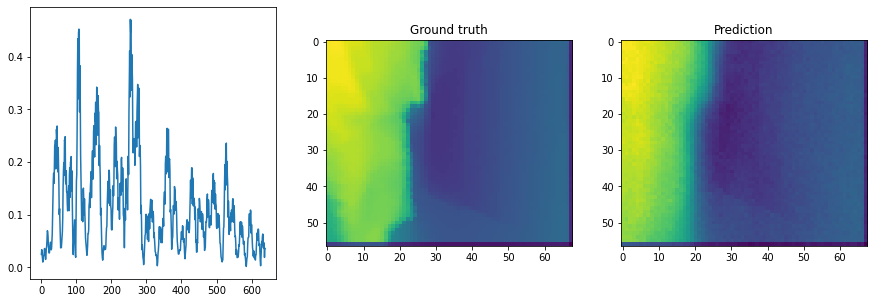

<Figure size 432x288 with 0 Axes>

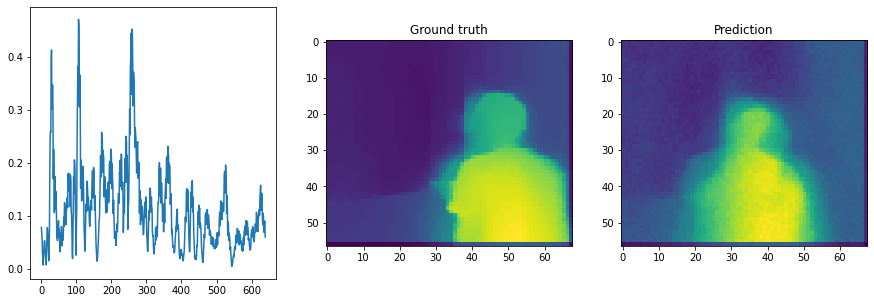

<Figure size 432x288 with 0 Axes>

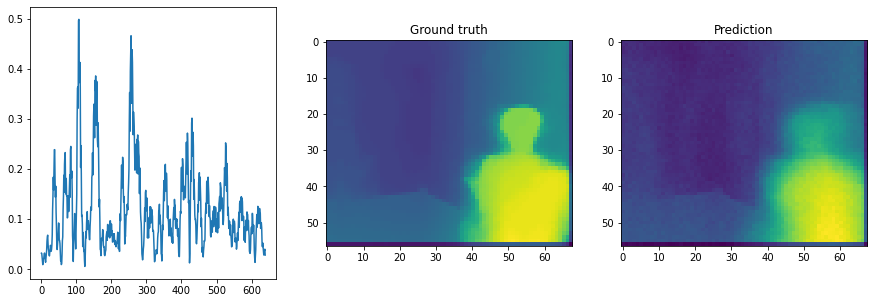

<Figure size 432x288 with 0 Axes>

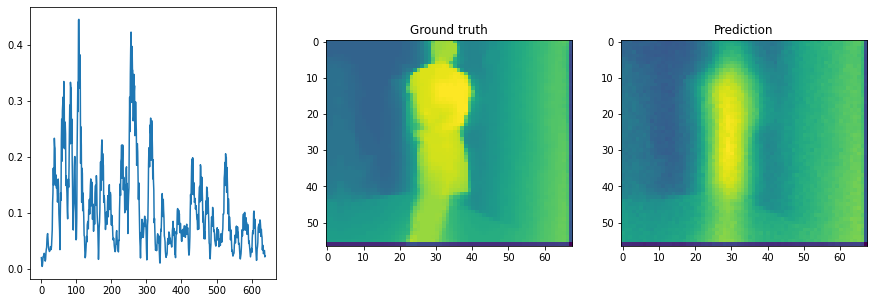

<Figure size 432x288 with 0 Axes>

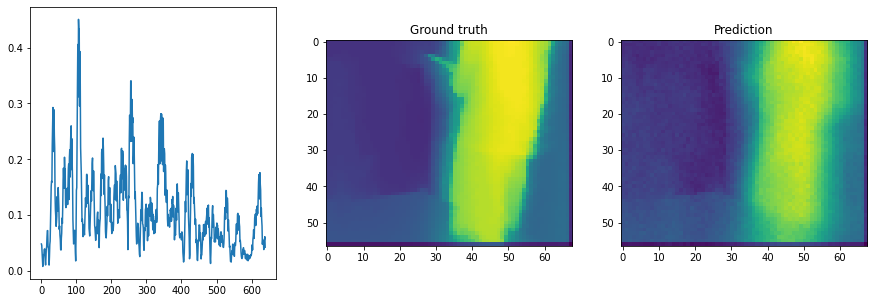

<Figure size 432x288 with 0 Axes>

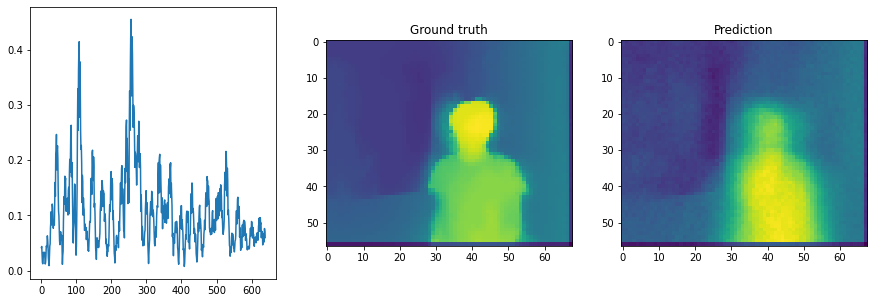

<Figure size 432x288 with 0 Axes>

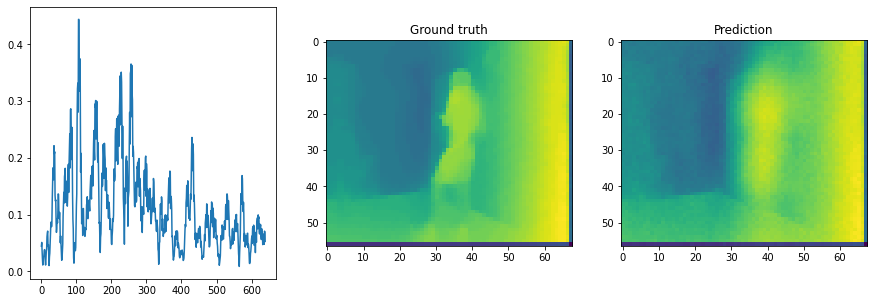

<Figure size 432x288 with 0 Axes>

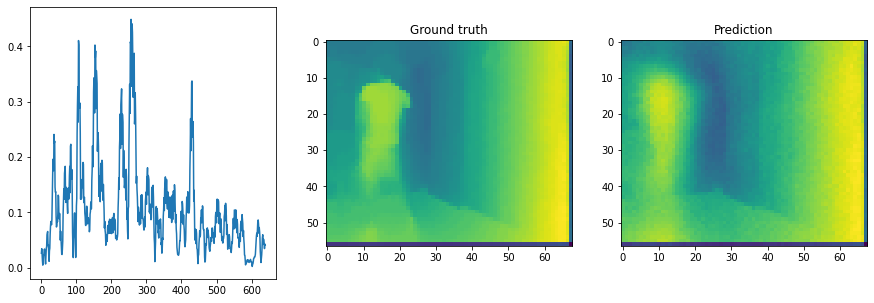

<Figure size 432x288 with 0 Axes>

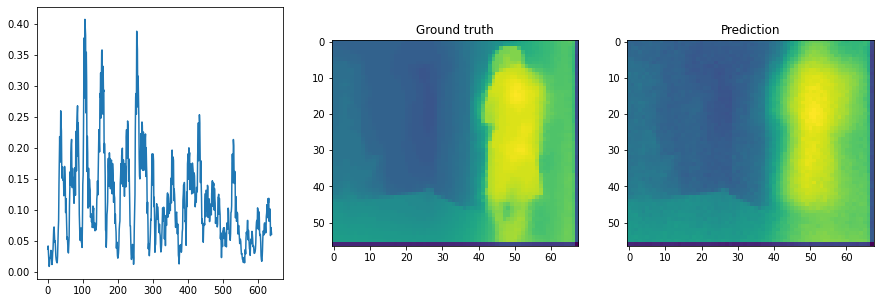

<Figure size 432x288 with 0 Axes>

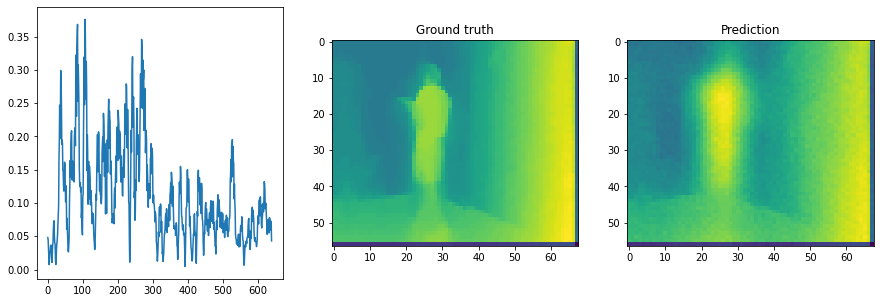

<Figure size 432x288 with 0 Axes>

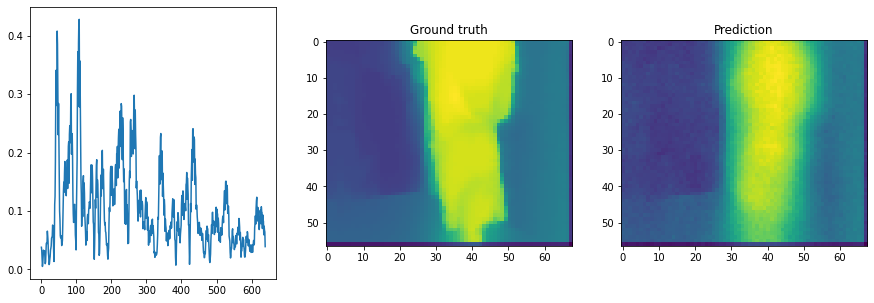

<Figure size 432x288 with 0 Axes>

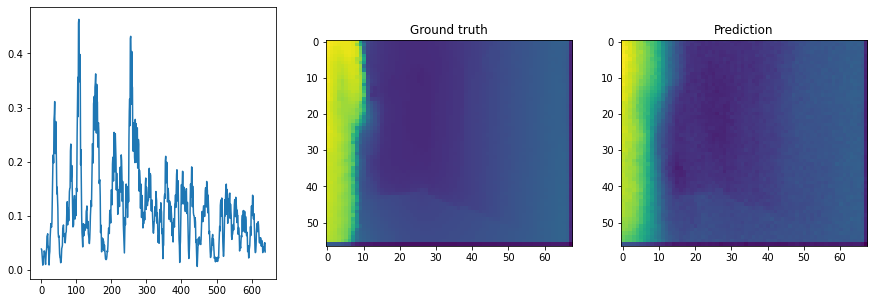

<Figure size 432x288 with 0 Axes>

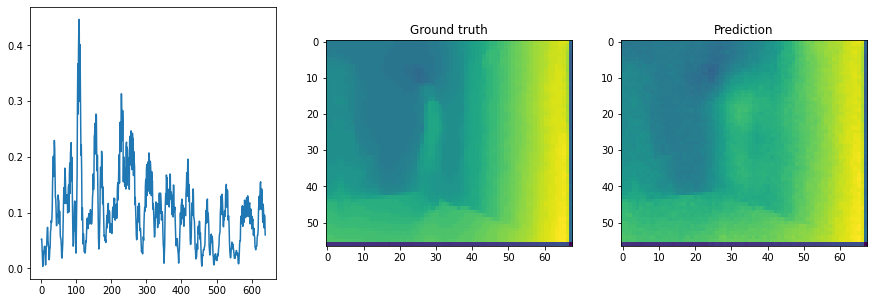

<Figure size 432x288 with 0 Axes>

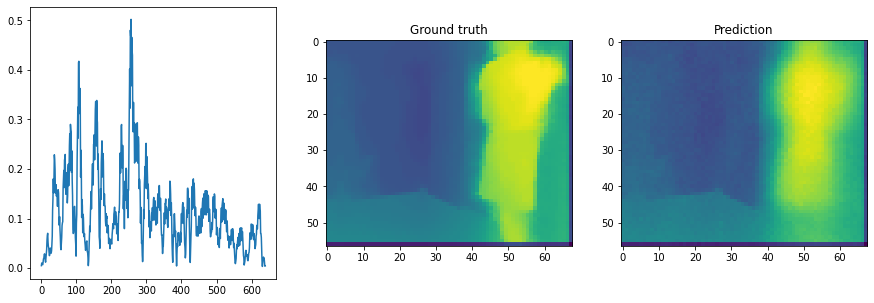

<Figure size 432x288 with 0 Axes>

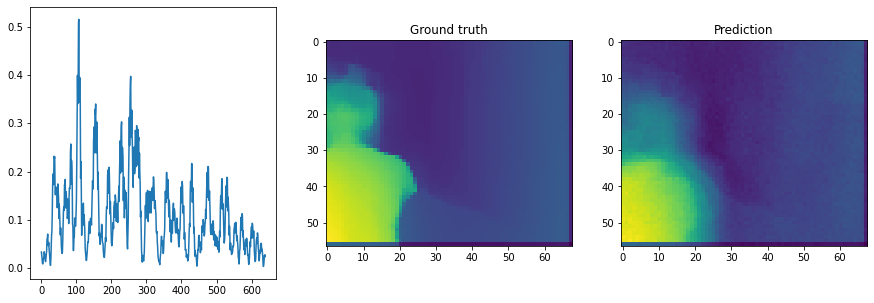

<Figure size 432x288 with 0 Axes>

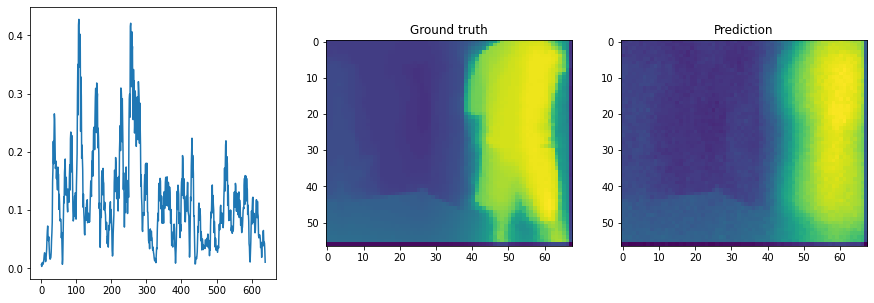



Batch 1 ###############


Batch 2 ###############
Average MSE: 0.0009359571267850697; Average SSIM: 0.9152888655662537


<Figure size 432x288 with 0 Axes>

In [11]:
MSE_metric = []
SSIM_metric = []
criterion_MSE = nn.MSELoss()
criterion_SSIM = SSIM(n_channels=1).cuda()

for idx, (audios, images) in enumerate(val_loader):
    audios, images = audios.to(device), images.to(device)
    pred_ims = model(audios)
    MSE_metric.append(criterion_MSE( pred_ims, images))
    SSIM_metric.append(criterion_SSIM( (pred_ims.unsqueeze(1)-pred_ims.min())/(pred_ims.max()-pred_ims.min()),
                                      (images.unsqueeze(1)-images.min())/(images.max()-images.min())))
    print(f"\n\nBatch {idx} ###############")
    if idx<1:
        for k, (audio, image, pred_image) in enumerate(zip(audios, images, pred_ims)):
            if k>15:
                break
            audio_np = np.array(audio.to('cpu').detach().numpy())
            image_np = np.array(image.to('cpu').detach().numpy())
            pred_image_np = np.array(pred_image.to('cpu').detach().numpy())
            fig, axs = plt.subplots(1,3, figsize=(15,5))
            axs[0].plot(audio_np)
            axs[1].imshow(image_np)
            axs[1].set_title("Ground truth")
            axs[2].imshow(pred_image_np)
            axs[2].set_title("Prediction")
            plt.show()
            plt.clf()
print(f"Average MSE: {torch.mean(torch.tensor(MSE_metric))}; Average SSIM: {torch.mean(torch.tensor(SSIM_metric))}")



Batch 0 ###############
MSE 6.0597096307901666e-05


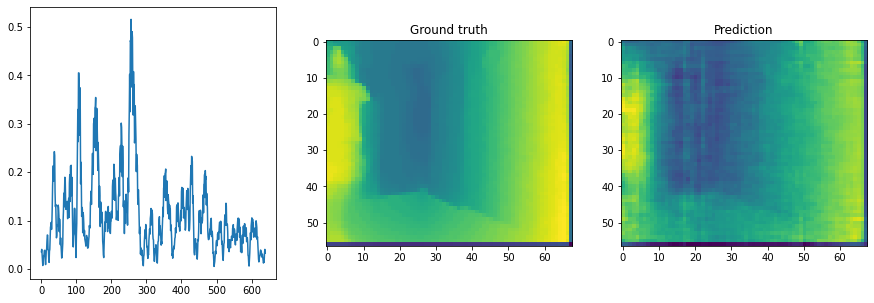

MSE 0.0006196612375788391


<Figure size 432x288 with 0 Axes>

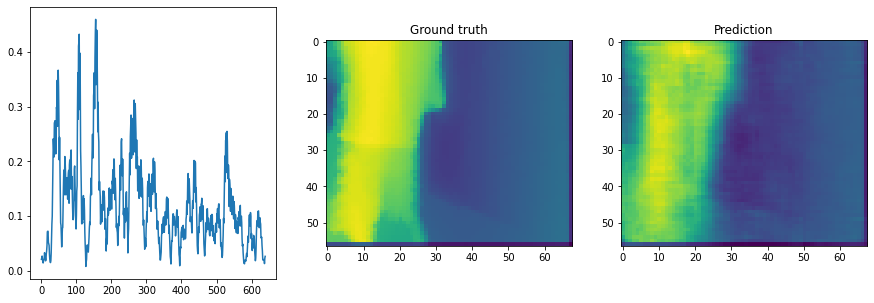

MSE 4.652098141377792e-05


<Figure size 432x288 with 0 Axes>

MSE 6.073610347812064e-05


<Figure size 432x288 with 0 Axes>

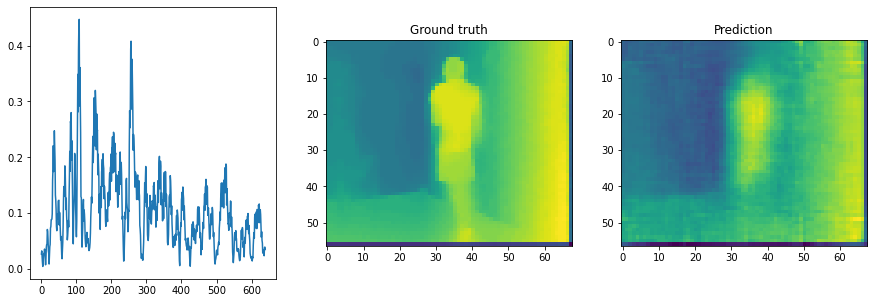

MSE 5.081827475805767e-05


<Figure size 432x288 with 0 Axes>

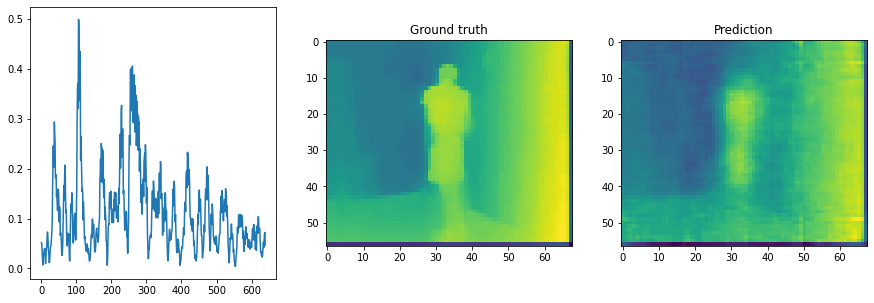

MSE 7.893723523011431e-05


<Figure size 432x288 with 0 Axes>

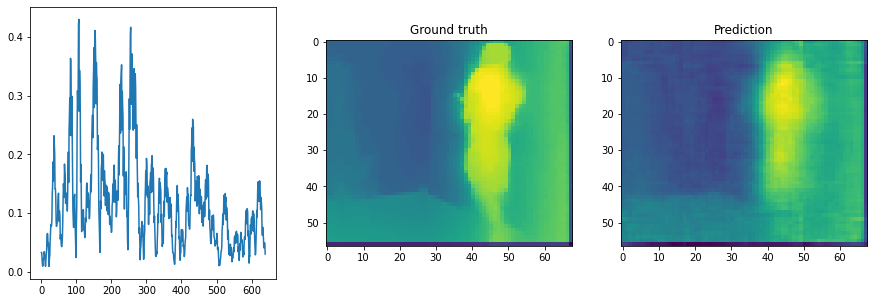

MSE 2.3465761842089705e-05


<Figure size 432x288 with 0 Axes>

MSE 0.000820665736682713


<Figure size 432x288 with 0 Axes>

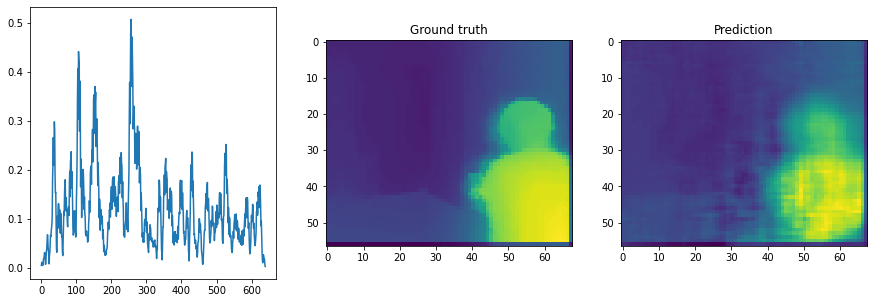

MSE 2.788544043141883e-05


<Figure size 432x288 with 0 Axes>

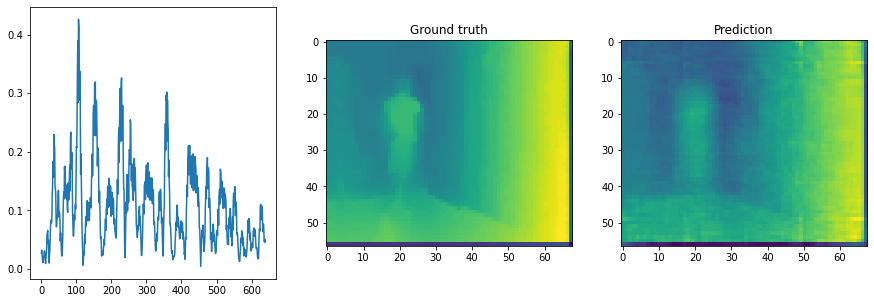

MSE 0.00019815641280729324


<Figure size 432x288 with 0 Axes>

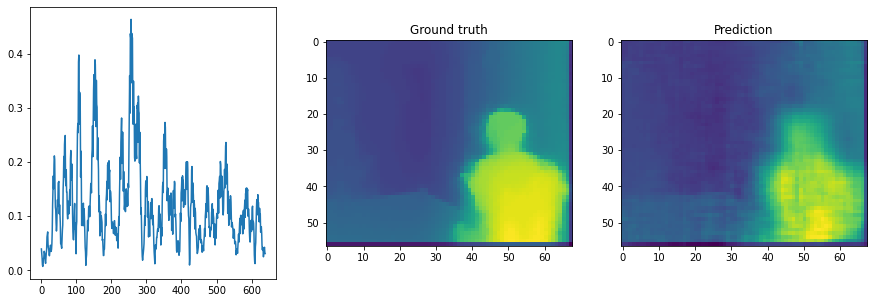

MSE 3.1775576644577086e-05


<Figure size 432x288 with 0 Axes>

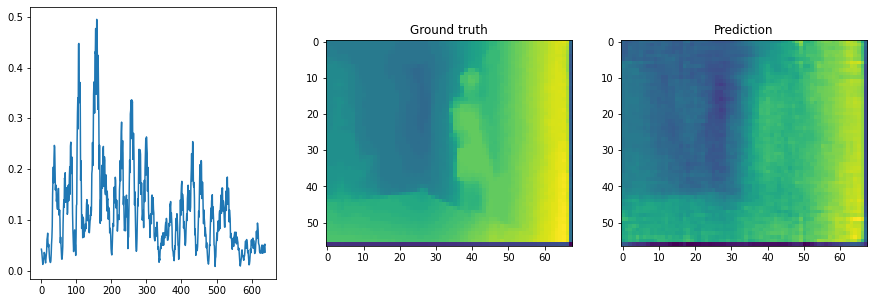

MSE 0.000883121567312628


<Figure size 432x288 with 0 Axes>

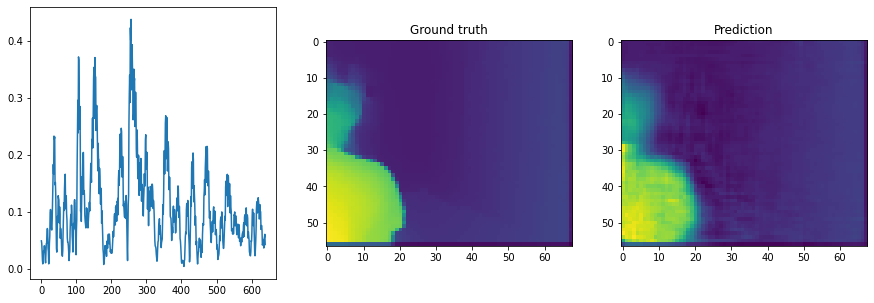

MSE 0.00022045547666493803


<Figure size 432x288 with 0 Axes>

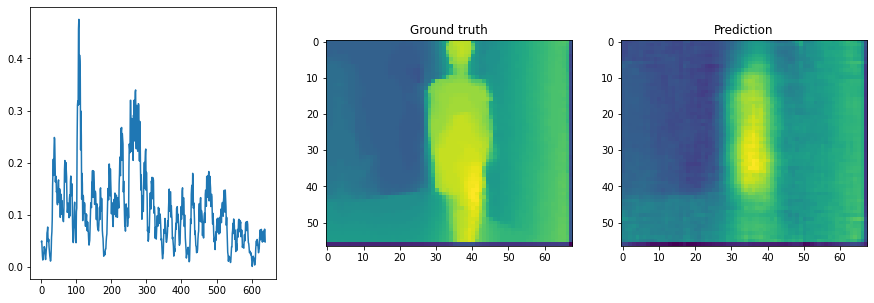

MSE 9.446171316085383e-05


<Figure size 432x288 with 0 Axes>

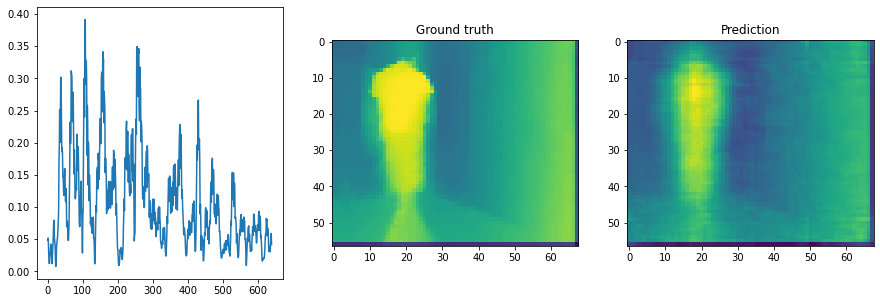

MSE 0.00031305081211030483


<Figure size 432x288 with 0 Axes>

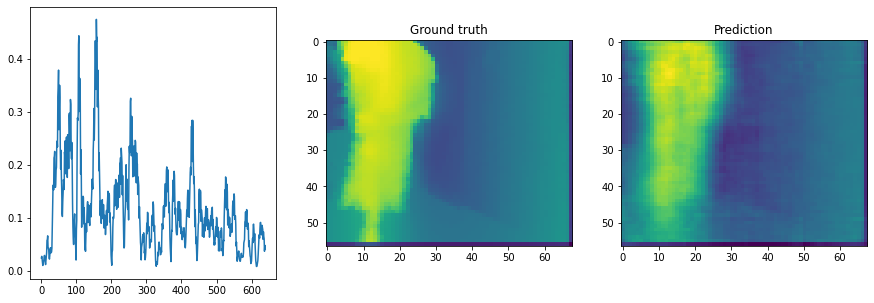

MSE 0.00017005686822813004


<Figure size 432x288 with 0 Axes>

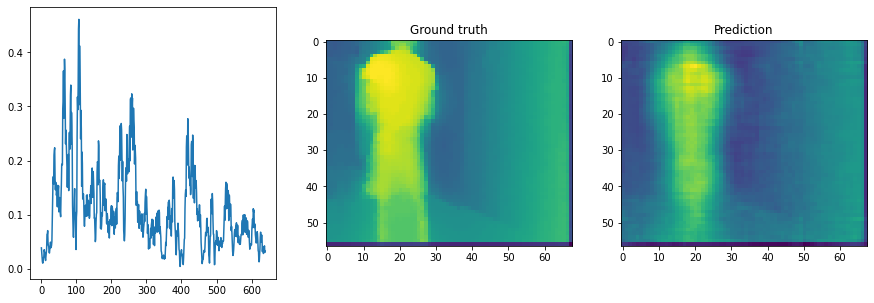

MSE 0.00016893123392947018


<Figure size 432x288 with 0 Axes>

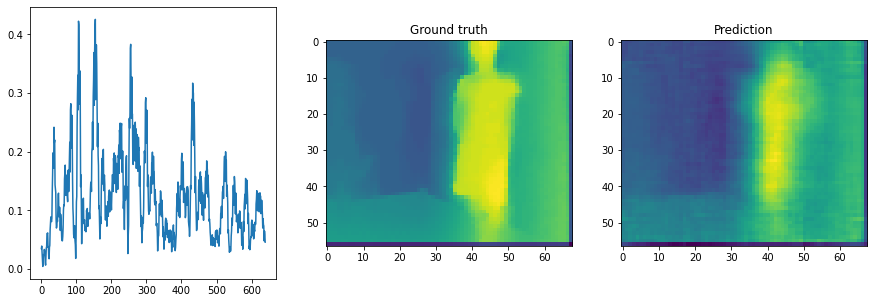

MSE 0.00022614572662860155


<Figure size 432x288 with 0 Axes>

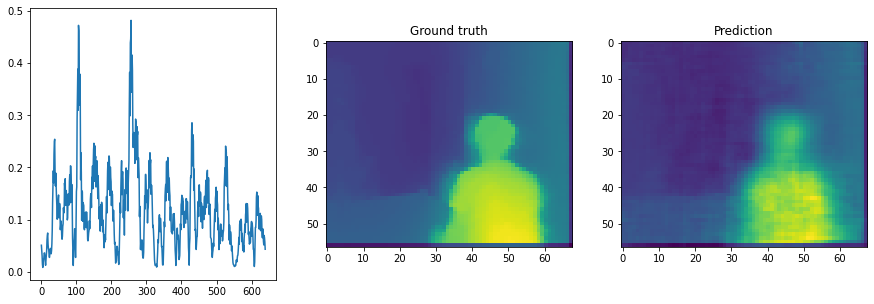

MSE 0.00013274114462547004


<Figure size 432x288 with 0 Axes>

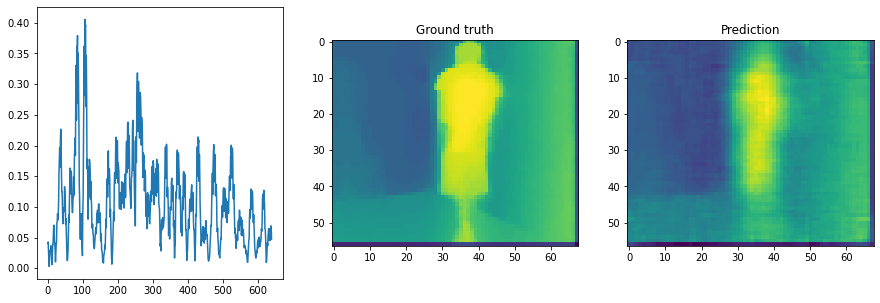

MSE 2.4743154426687397e-05


<Figure size 432x288 with 0 Axes>

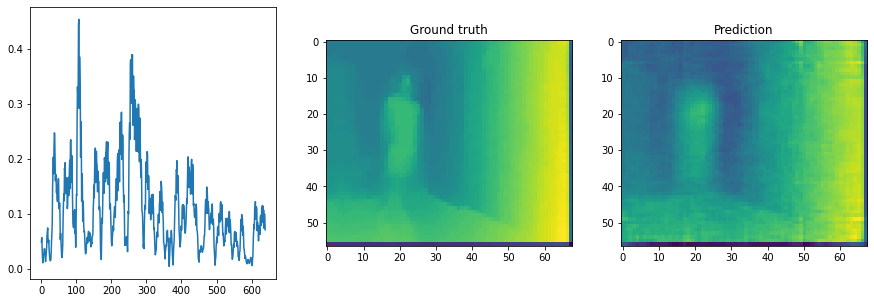

MSE 0.0004377402947284281


<Figure size 432x288 with 0 Axes>

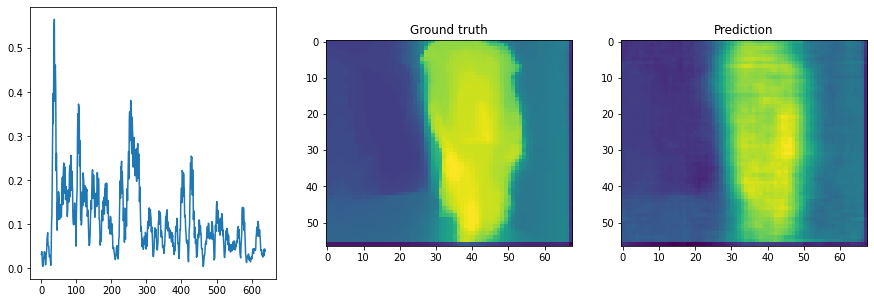

MSE 0.0006504791090264916


<Figure size 432x288 with 0 Axes>

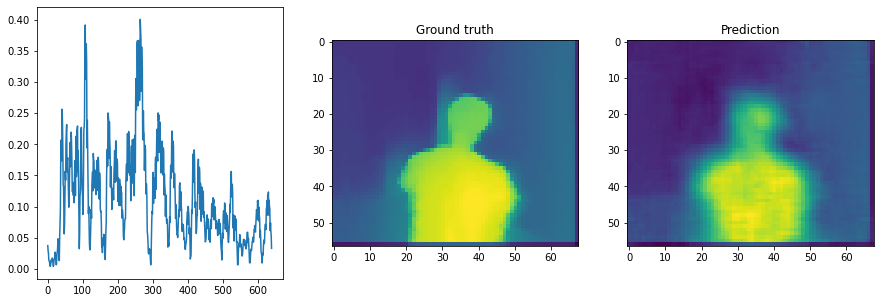

MSE 0.00023584473819937557


<Figure size 432x288 with 0 Axes>

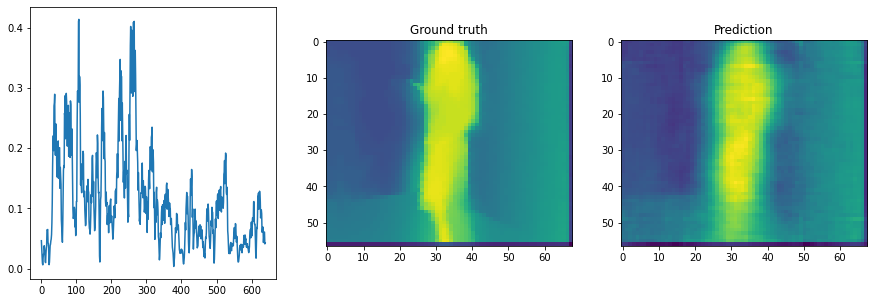

MSE 0.0004855574807152152


<Figure size 432x288 with 0 Axes>

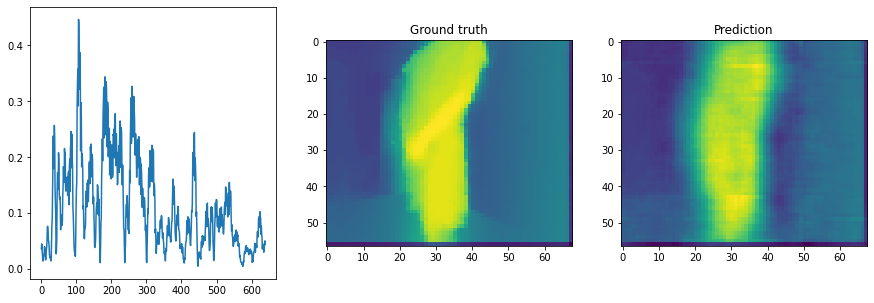

MSE 1.919045826070942e-05


<Figure size 432x288 with 0 Axes>

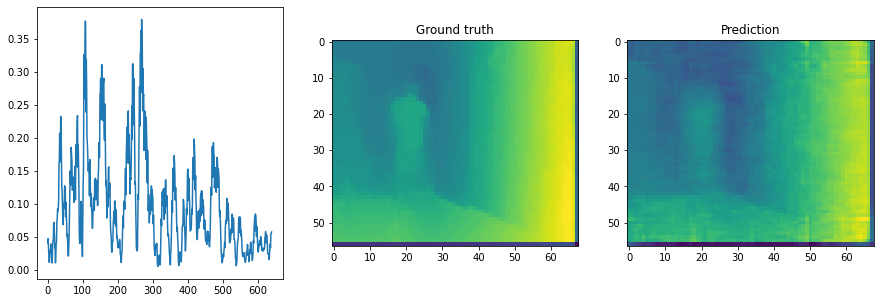

MSE 0.00022509740665555


<Figure size 432x288 with 0 Axes>

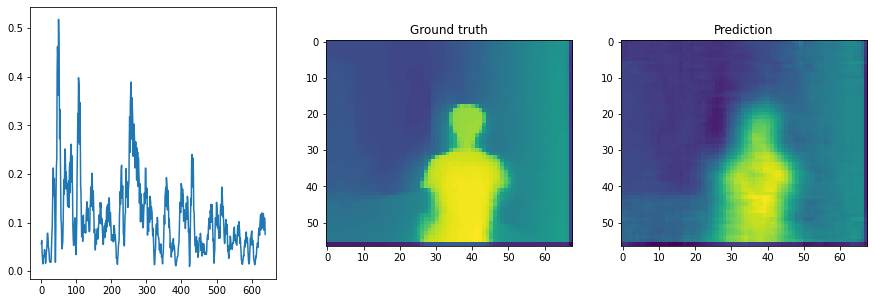

MSE 2.0422541638254188e-05


<Figure size 432x288 with 0 Axes>

MSE 9.05108026927337e-05


<Figure size 432x288 with 0 Axes>

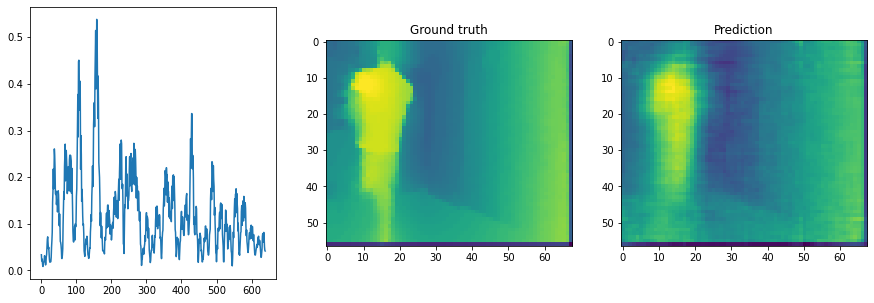

MSE 0.0005533711519092321


<Figure size 432x288 with 0 Axes>

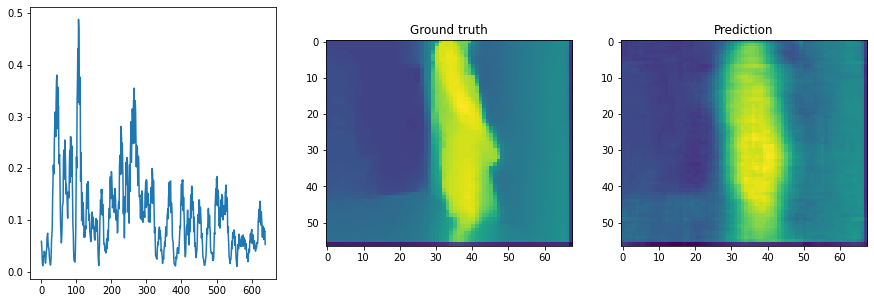

MSE 0.0003086714423261583


<Figure size 432x288 with 0 Axes>

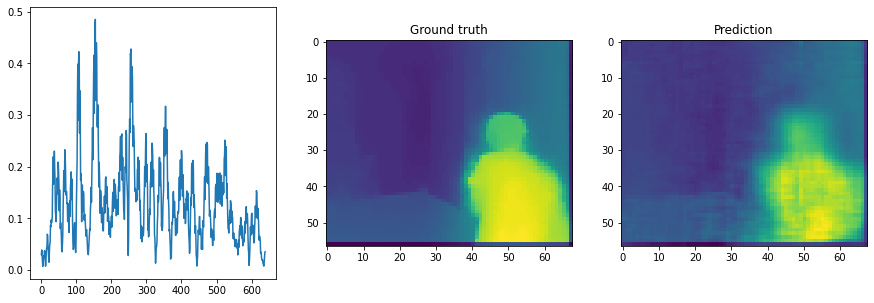

MSE 4.304093454265967e-05


<Figure size 432x288 with 0 Axes>

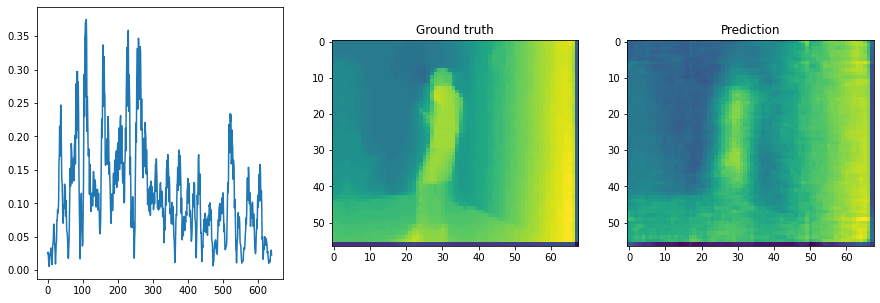

MSE 2.4324117475771345e-05


<Figure size 432x288 with 0 Axes>

MSE 0.0001343583280686289


<Figure size 432x288 with 0 Axes>

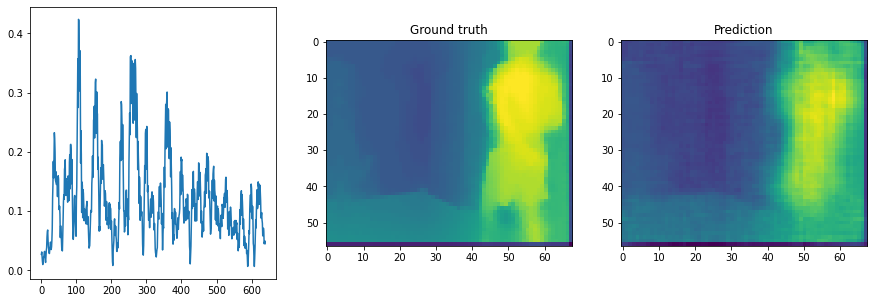

MSE 0.00074187689460814


<Figure size 432x288 with 0 Axes>

MSE 1.9948600311181508e-05


<Figure size 432x288 with 0 Axes>

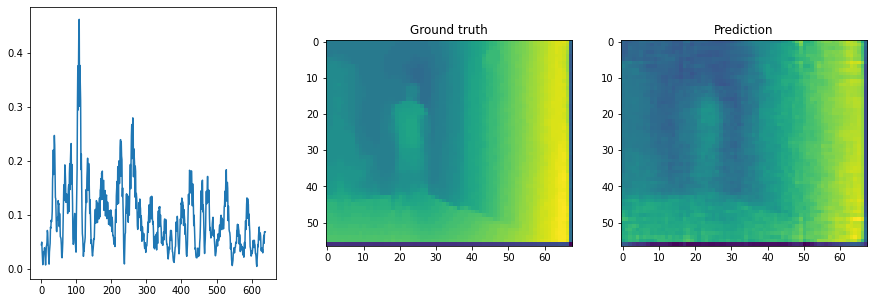

MSE 0.00174850900657475


<Figure size 432x288 with 0 Axes>

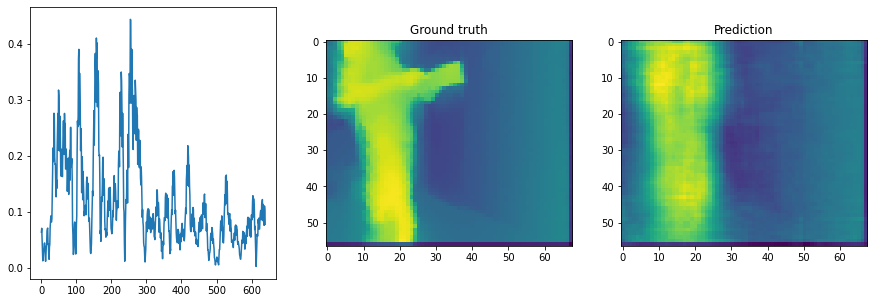

MSE 0.00035510380985215306


<Figure size 432x288 with 0 Axes>

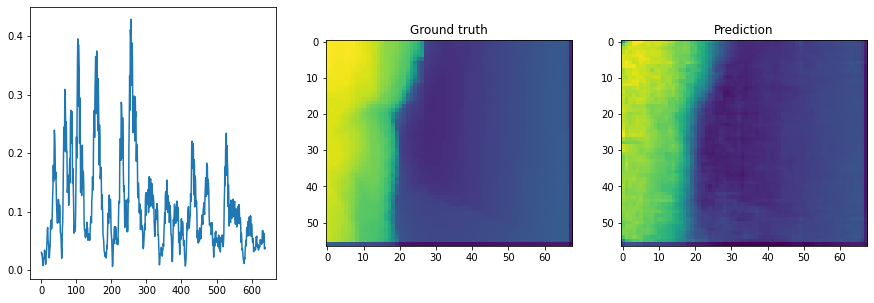

MSE 0.0003861521545331925


<Figure size 432x288 with 0 Axes>

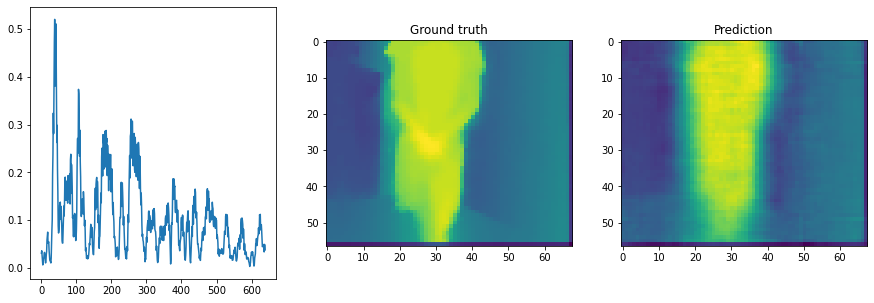

MSE 5.489102841238491e-05


<Figure size 432x288 with 0 Axes>

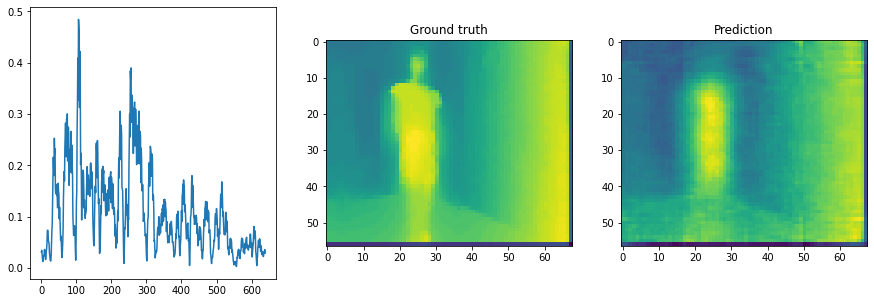

MSE 3.214372190996073e-05


<Figure size 432x288 with 0 Axes>

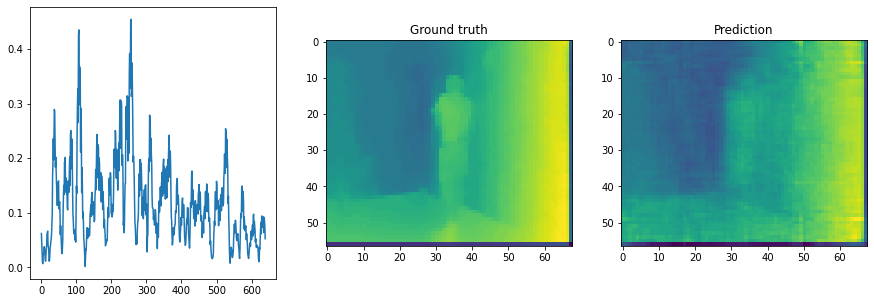

MSE 0.00015100017481017858


<Figure size 432x288 with 0 Axes>

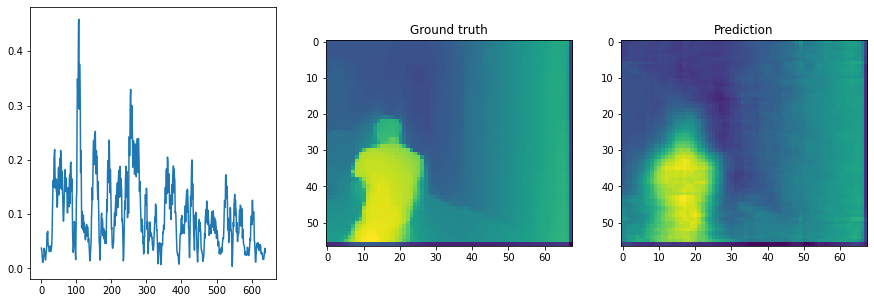

MSE 1.7396318071405403e-05


<Figure size 432x288 with 0 Axes>

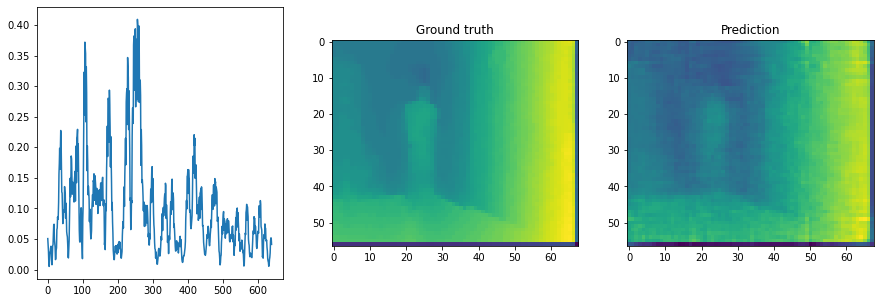

MSE 0.0006952451076358557


<Figure size 432x288 with 0 Axes>

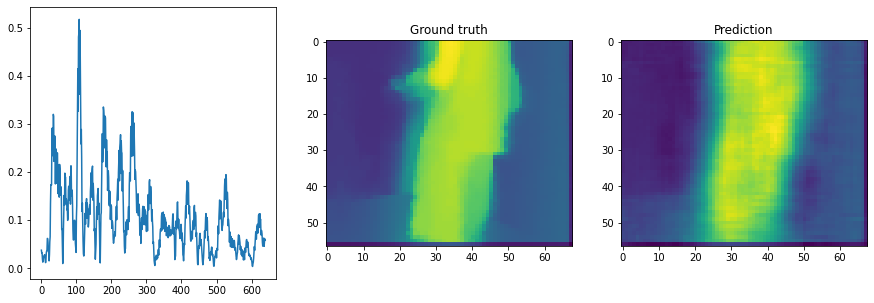

MSE 0.0003864853351842612


<Figure size 432x288 with 0 Axes>

MSE 0.0003998402098659426


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [15]:
model.eval()
for idx, (audios, images) in enumerate(train_loader):
    audios = audios.to(device)
    pred_ims = model(audios)
    print(f"\n\nBatch {idx} ###############")
    for audio, image, pred_image in zip(audios, images, pred_ims):
        print(f"MSE {criterion( pred_image, image.to(device))}")
        audio_np = np.array(audio.to('cpu').detach().numpy())
        image_np = np.array(image.to('cpu').detach().numpy())
        pred_image_np = np.array(pred_image.to('cpu').detach().numpy())
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        axs[0].plot(audio_np)
        axs[1].imshow(image_np)
        axs[1].set_title("Ground truth")
        axs[2].imshow(pred_image_np)
        axs[2].set_title("Prediction")
        plt.show()
        plt.clf()
    if idx==0:
        break

# FC+Conv



Batch 0 ###############


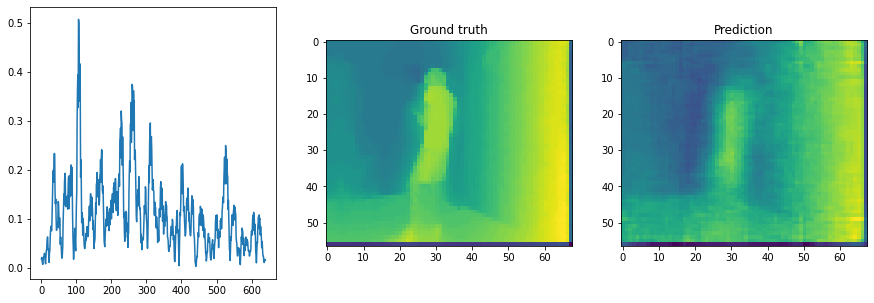

<Figure size 432x288 with 0 Axes>

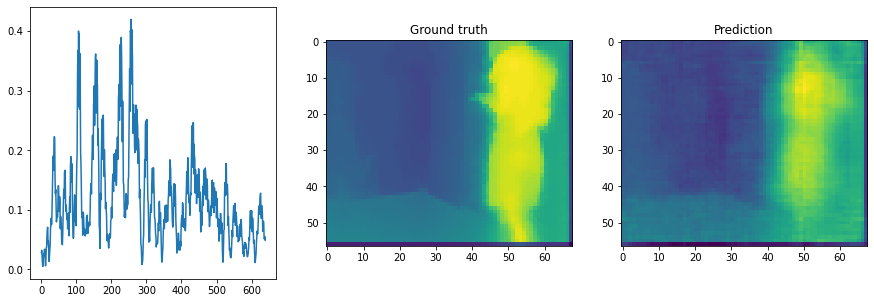

<Figure size 432x288 with 0 Axes>

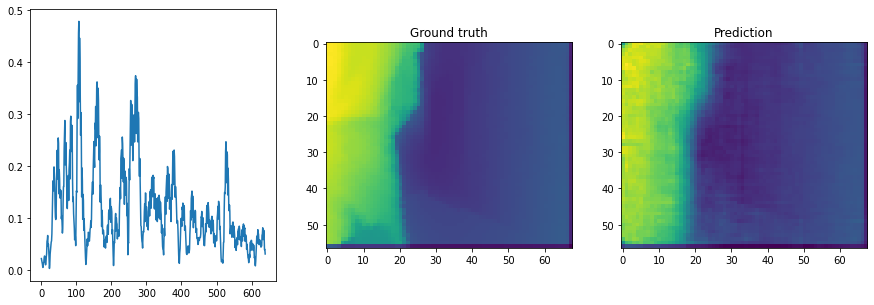

<Figure size 432x288 with 0 Axes>

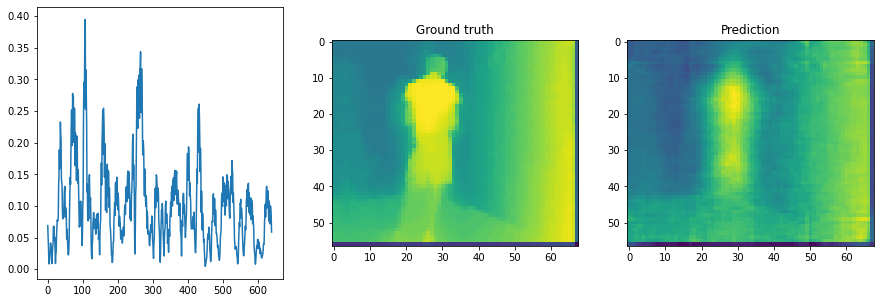

<Figure size 432x288 with 0 Axes>

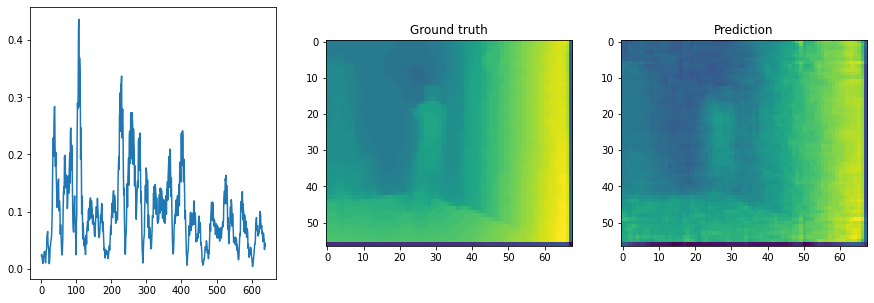

<Figure size 432x288 with 0 Axes>

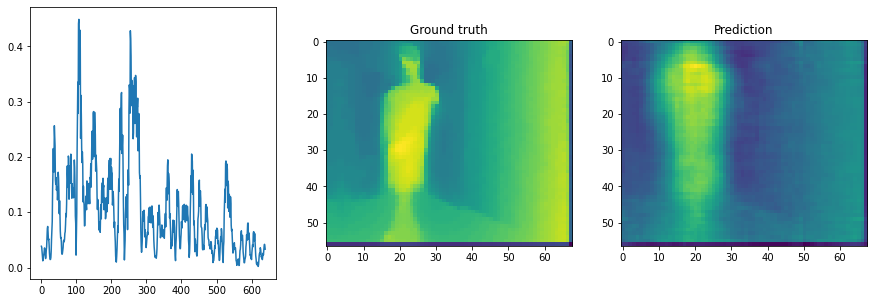

<Figure size 432x288 with 0 Axes>

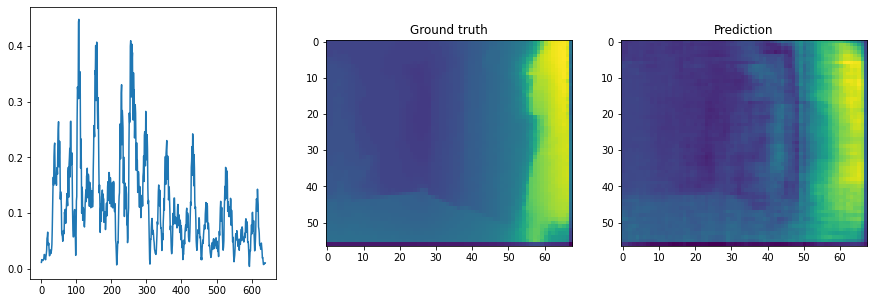

<Figure size 432x288 with 0 Axes>

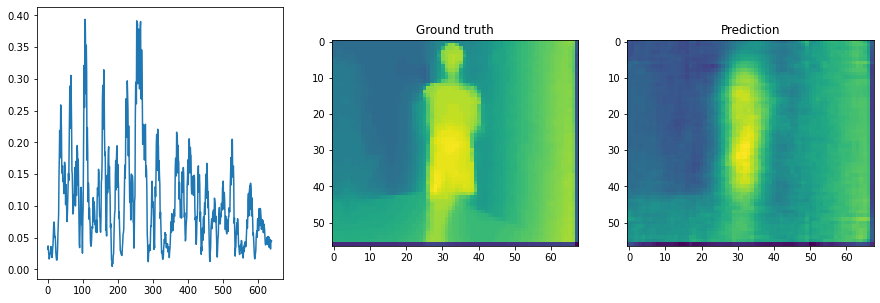

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

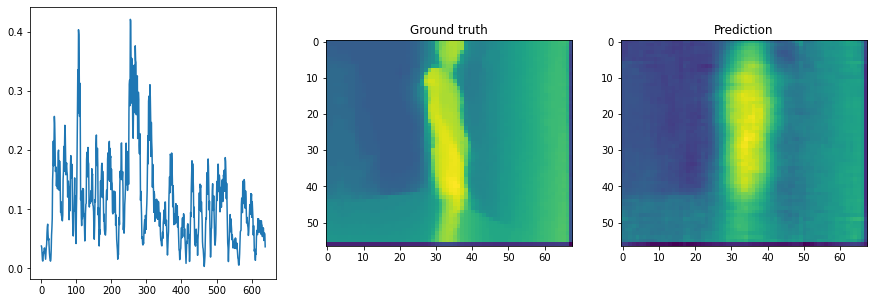

<Figure size 432x288 with 0 Axes>

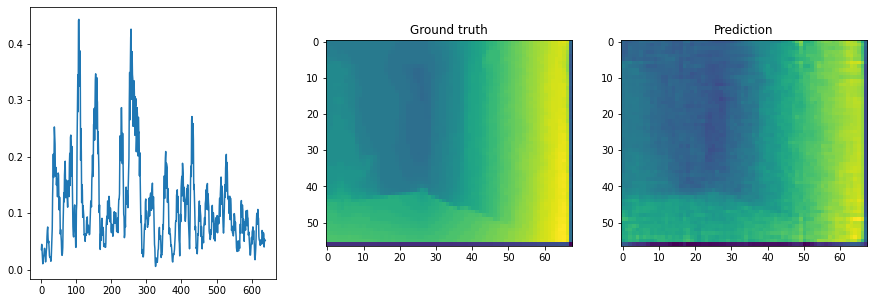

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

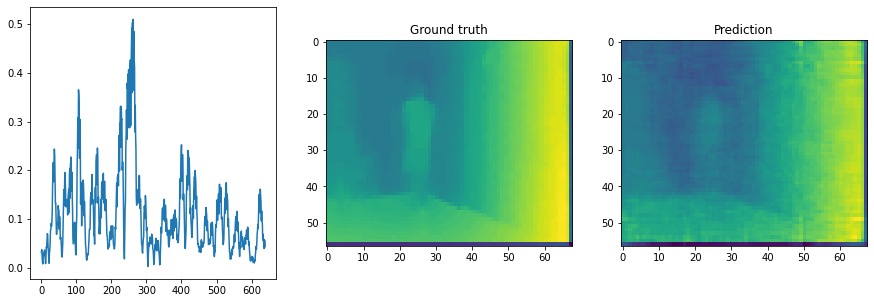

<Figure size 432x288 with 0 Axes>

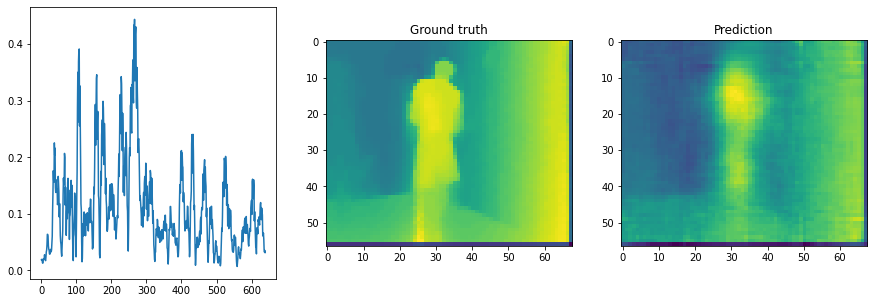

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>



Batch 1 ###############


Batch 2 ###############
Average MSE: 0.0011320185149088502; Average SSIM: 0.9064540863037109


<Figure size 432x288 with 0 Axes>

In [10]:
MSE_metric = []
SSIM_metric = []
criterion_MSE = nn.MSELoss()
criterion_SSIM = SSIM(n_channels=1).cuda()

for idx, (audios, images) in enumerate(val_loader):
    audios, images = audios.to(device), images.to(device)
    pred_ims = model(audios)
    MSE_metric.append(criterion_MSE( pred_ims, images))
    SSIM_metric.append(criterion_SSIM( (pred_ims.unsqueeze(1)-pred_ims.min())/(pred_ims.max()-pred_ims.min()),
                                      (images.unsqueeze(1)-images.min())/(images.max()-images.min())))
    print(f"\n\nBatch {idx} ###############")
    if idx<1:
        for k, (audio, image, pred_image) in enumerate(zip(audios, images, pred_ims)):
            if k>15:
                break
            audio_np = np.array(audio.to('cpu').detach().numpy())
            image_np = np.array(image.to('cpu').detach().numpy())
            pred_image_np = np.array(pred_image.to('cpu').detach().numpy())
            fig, axs = plt.subplots(1,3, figsize=(15,5))
            axs[0].plot(audio_np)
            axs[1].imshow(image_np)
            axs[1].set_title("Ground truth")
            axs[2].imshow(pred_image_np)
            axs[2].set_title("Prediction")
            plt.show()
            plt.clf()
print(f"Average MSE: {torch.mean(torch.tensor(MSE_metric))}; Average SSIM: {torch.mean(torch.tensor(SSIM_metric))}")



Batch 0 ###############
MSE 6.0597096307901666e-05


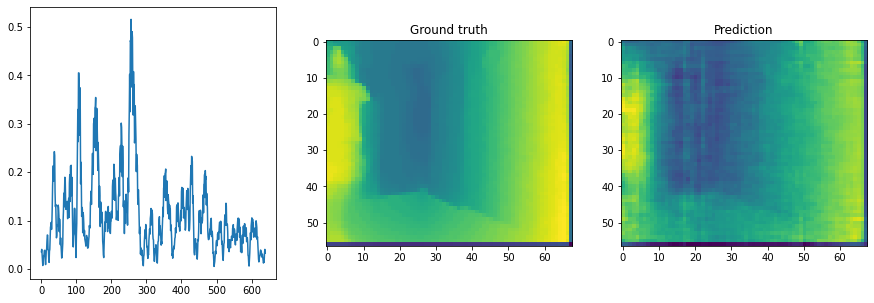

MSE 0.0006196612375788391


<Figure size 432x288 with 0 Axes>

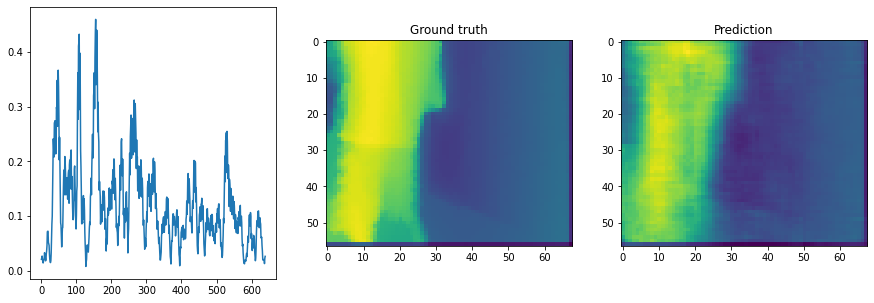

MSE 4.652098141377792e-05


<Figure size 432x288 with 0 Axes>

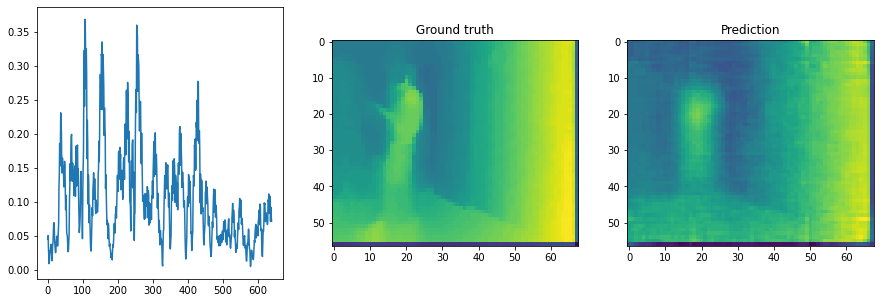

MSE 6.073610347812064e-05


<Figure size 432x288 with 0 Axes>

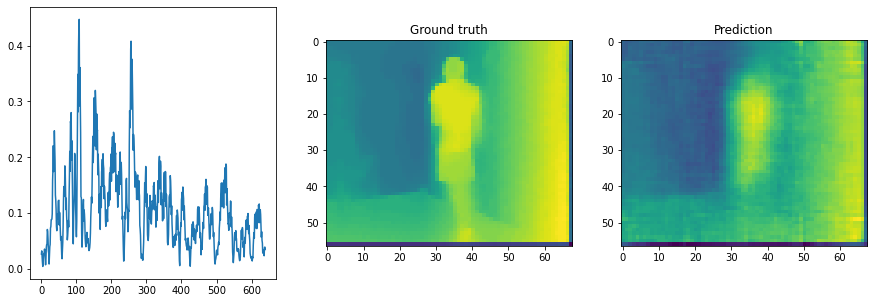

MSE 5.081827475805767e-05


<Figure size 432x288 with 0 Axes>

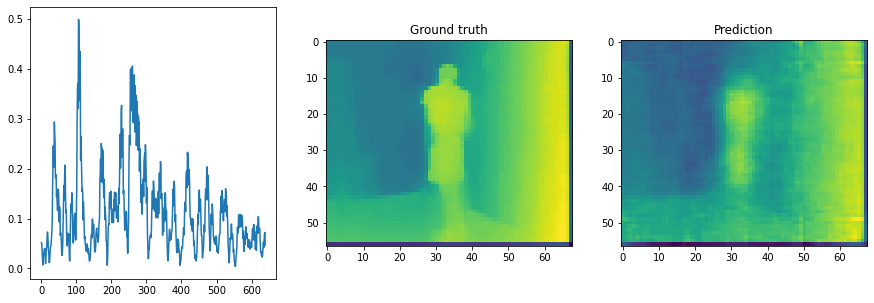

MSE 7.893723523011431e-05


<Figure size 432x288 with 0 Axes>

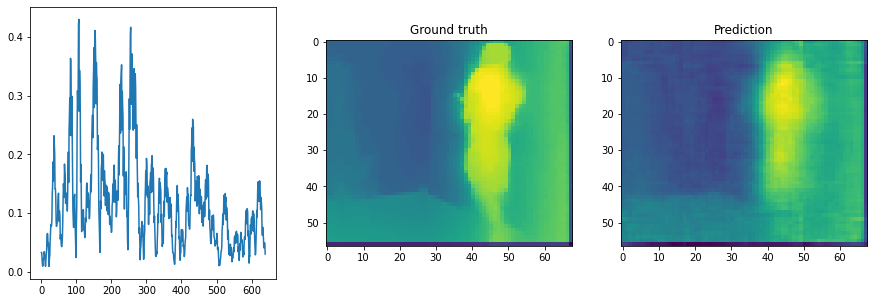

MSE 2.3465761842089705e-05


<Figure size 432x288 with 0 Axes>

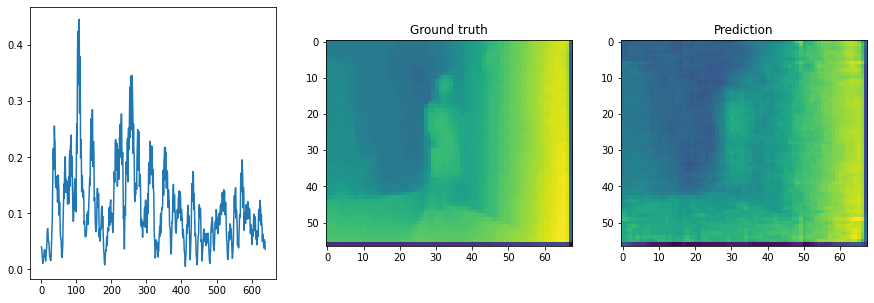

MSE 0.000820665736682713


<Figure size 432x288 with 0 Axes>

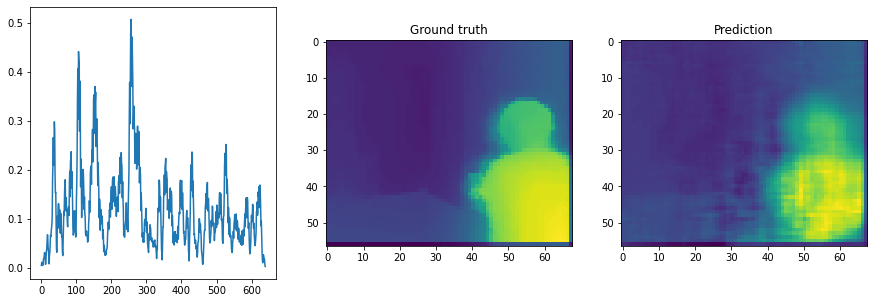

MSE 2.788544043141883e-05


<Figure size 432x288 with 0 Axes>

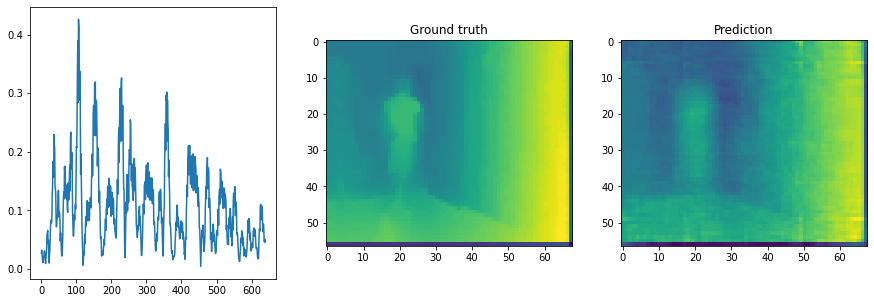

MSE 0.00019815641280729324


<Figure size 432x288 with 0 Axes>

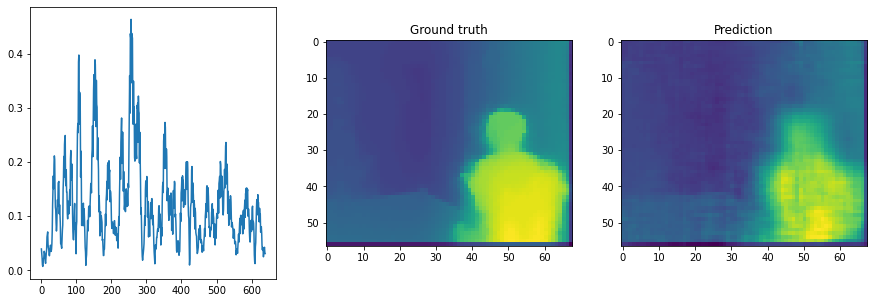

MSE 3.1775576644577086e-05


<Figure size 432x288 with 0 Axes>

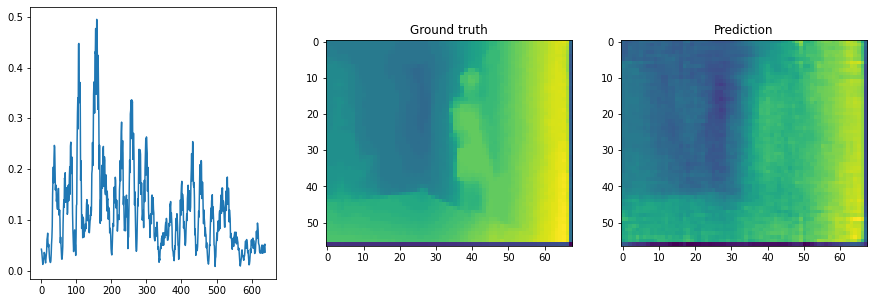

MSE 0.000883121567312628


<Figure size 432x288 with 0 Axes>

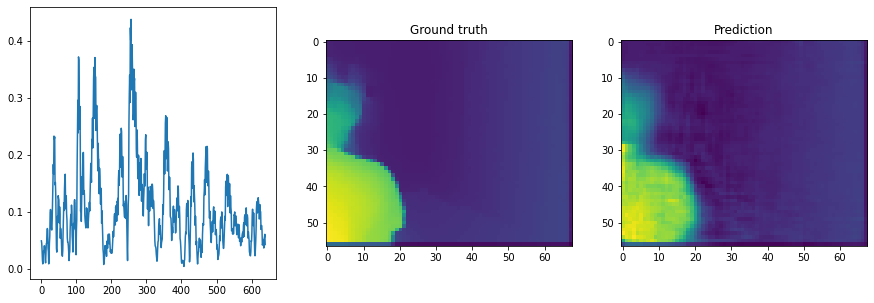

MSE 0.00022045547666493803


<Figure size 432x288 with 0 Axes>

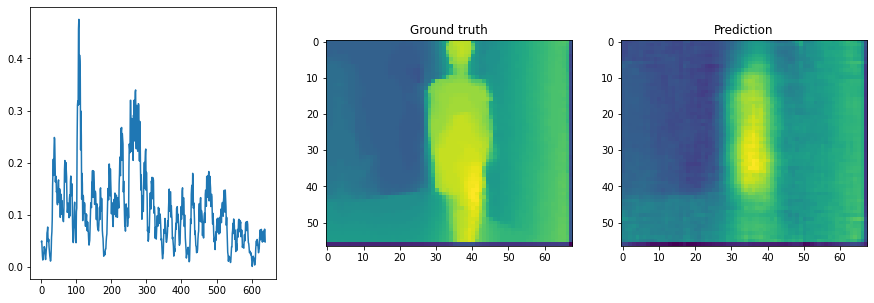

MSE 9.446171316085383e-05


<Figure size 432x288 with 0 Axes>

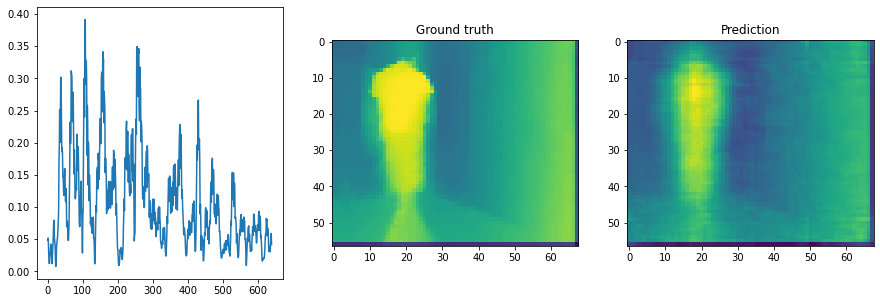

MSE 0.00031305081211030483


<Figure size 432x288 with 0 Axes>

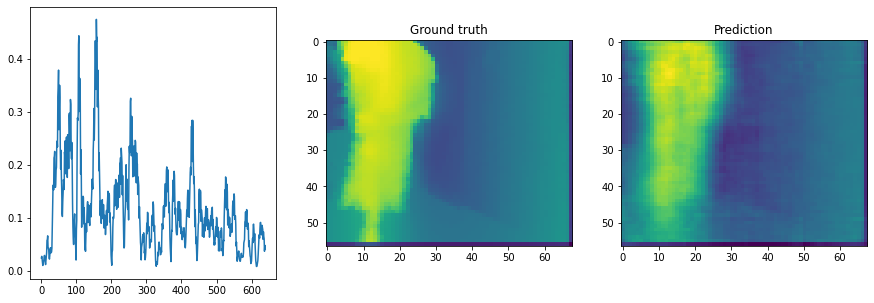

MSE 0.00017005686822813004


<Figure size 432x288 with 0 Axes>

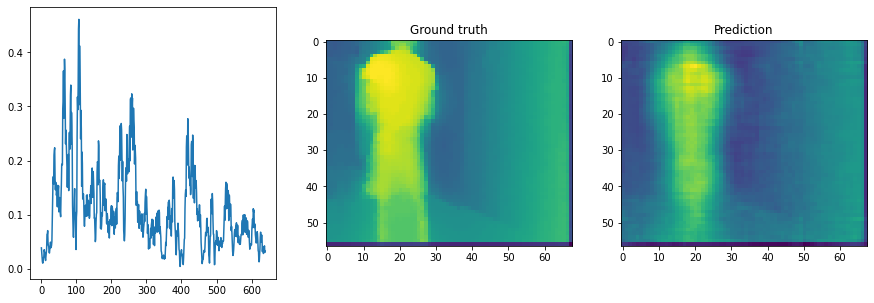

MSE 0.00016893123392947018


<Figure size 432x288 with 0 Axes>

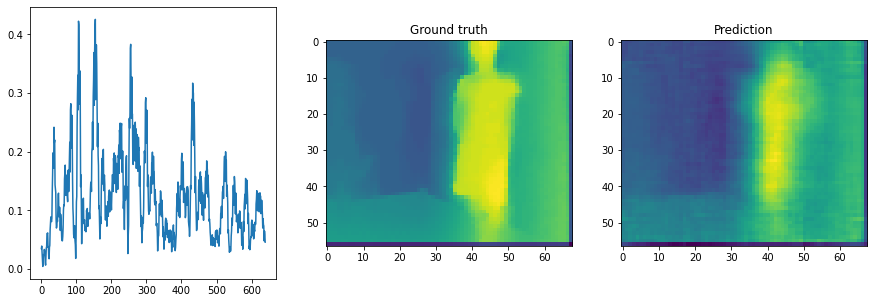

MSE 0.00022614572662860155


<Figure size 432x288 with 0 Axes>

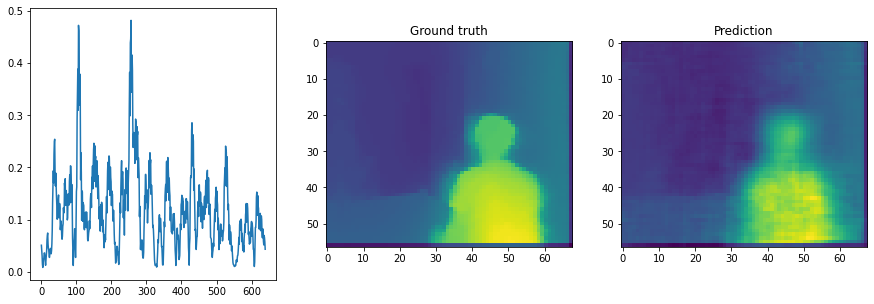

MSE 0.00013274114462547004


<Figure size 432x288 with 0 Axes>

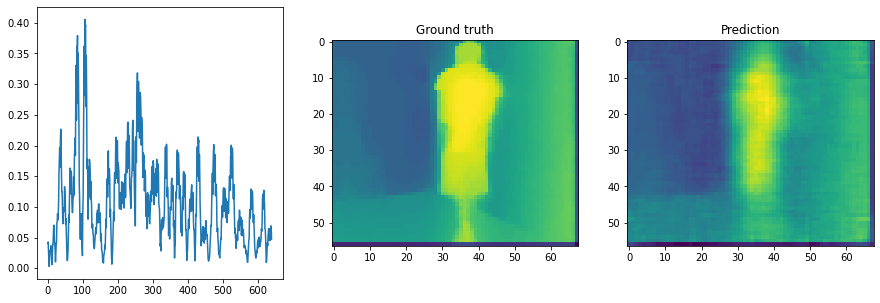

MSE 2.4743154426687397e-05


<Figure size 432x288 with 0 Axes>

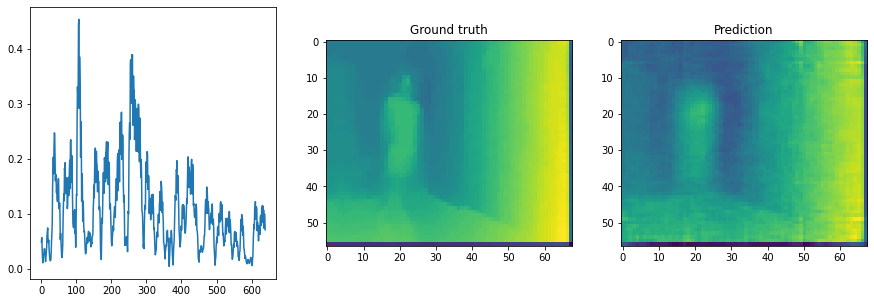

MSE 0.0004377402947284281


<Figure size 432x288 with 0 Axes>

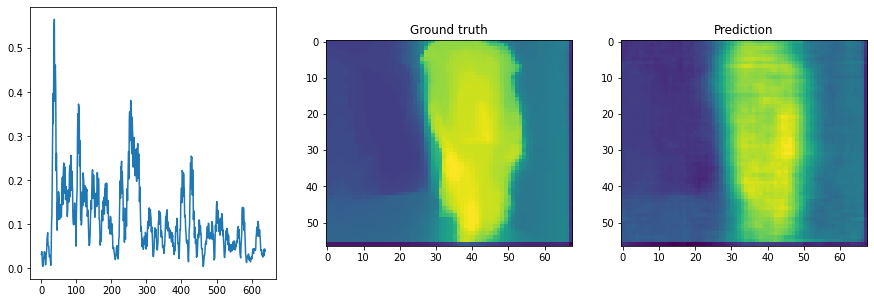

MSE 0.0006504791090264916


<Figure size 432x288 with 0 Axes>

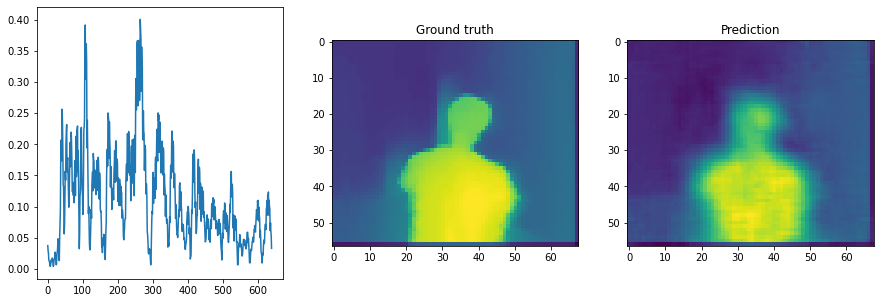

MSE 0.00023584473819937557


<Figure size 432x288 with 0 Axes>

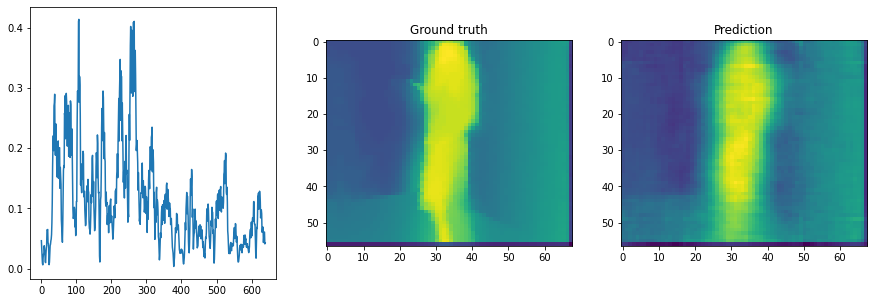

MSE 0.0004855574807152152


<Figure size 432x288 with 0 Axes>

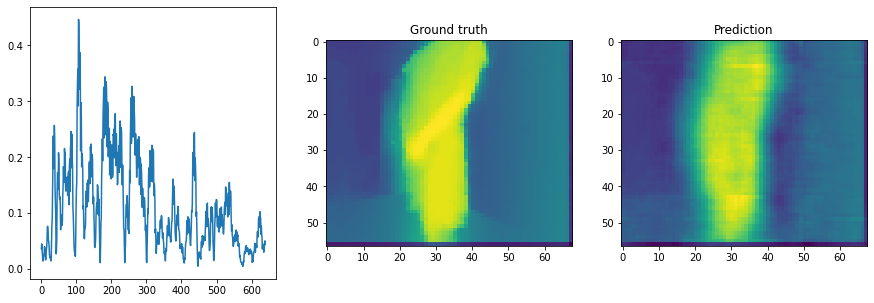

MSE 1.919045826070942e-05


<Figure size 432x288 with 0 Axes>

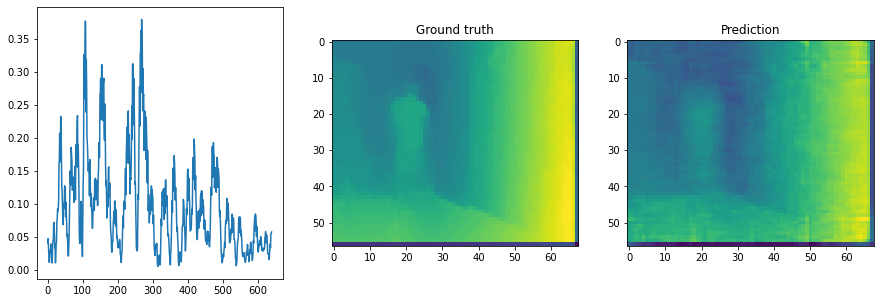

MSE 0.00022509740665555


<Figure size 432x288 with 0 Axes>

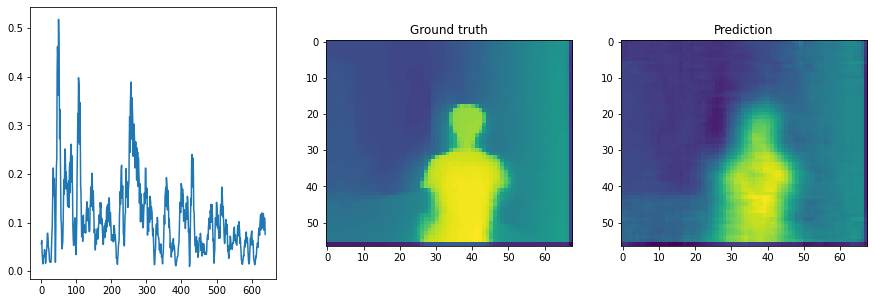

MSE 2.0422541638254188e-05


<Figure size 432x288 with 0 Axes>

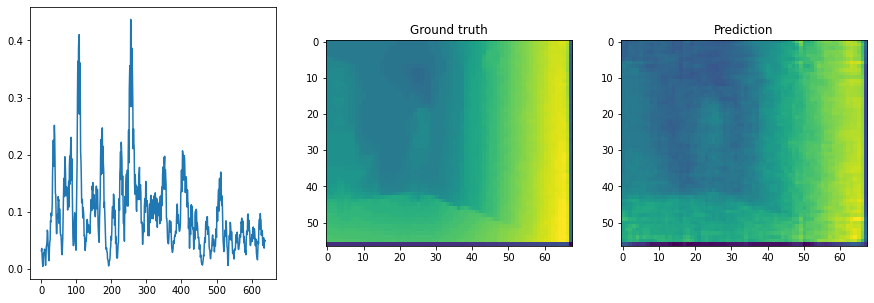

MSE 9.05108026927337e-05


<Figure size 432x288 with 0 Axes>

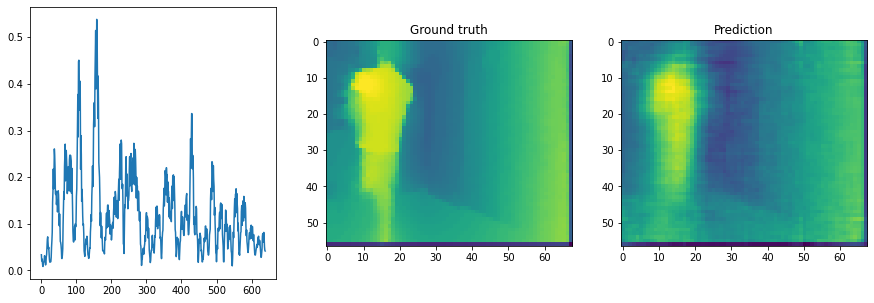

MSE 0.0005533711519092321


<Figure size 432x288 with 0 Axes>

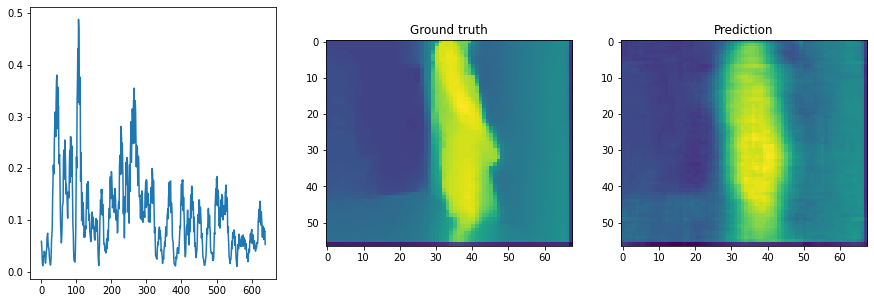

MSE 0.0003086714423261583


<Figure size 432x288 with 0 Axes>

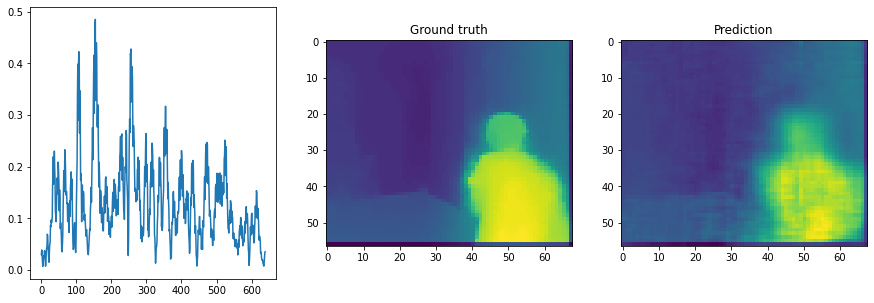

MSE 4.304093454265967e-05


<Figure size 432x288 with 0 Axes>

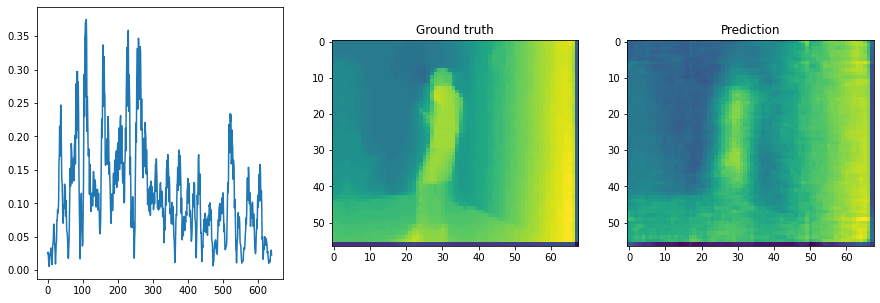

MSE 2.4324117475771345e-05


<Figure size 432x288 with 0 Axes>

MSE 0.0001343583280686289


<Figure size 432x288 with 0 Axes>

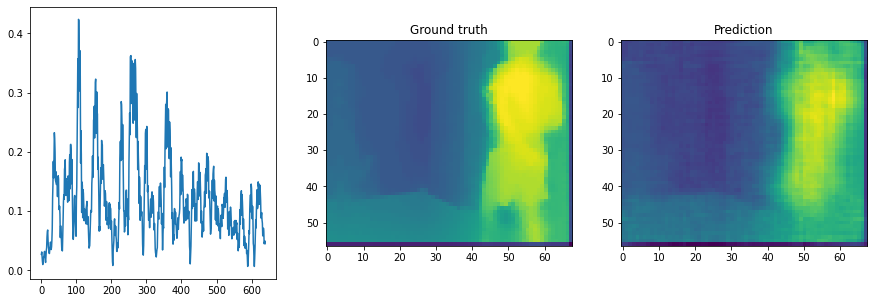

MSE 0.00074187689460814


<Figure size 432x288 with 0 Axes>

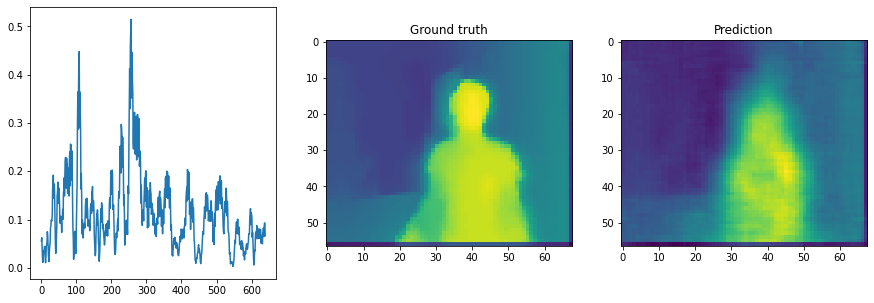

MSE 1.9948600311181508e-05


<Figure size 432x288 with 0 Axes>

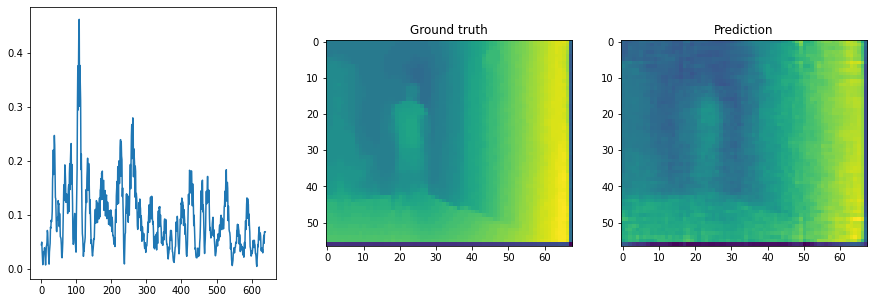

MSE 0.00174850900657475


<Figure size 432x288 with 0 Axes>

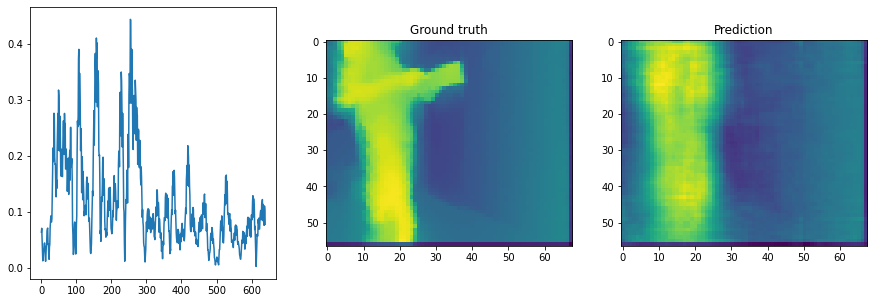

MSE 0.00035510380985215306


<Figure size 432x288 with 0 Axes>

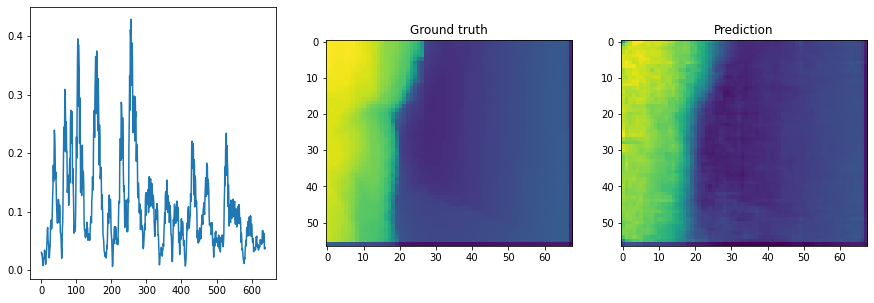

MSE 0.0003861521545331925


<Figure size 432x288 with 0 Axes>

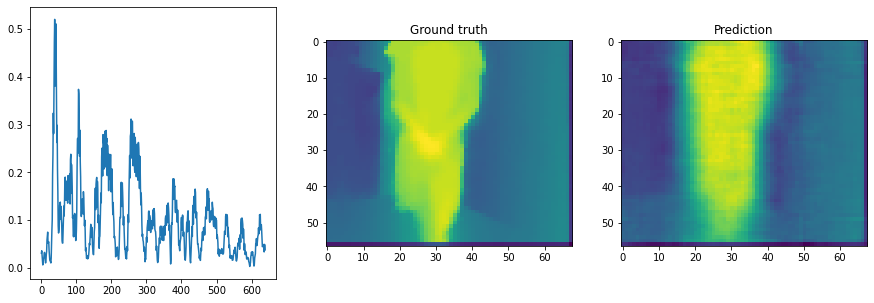

MSE 5.489102841238491e-05


<Figure size 432x288 with 0 Axes>

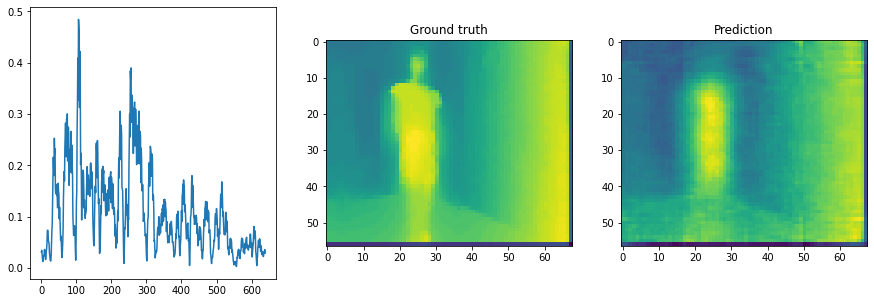

MSE 3.214372190996073e-05


<Figure size 432x288 with 0 Axes>

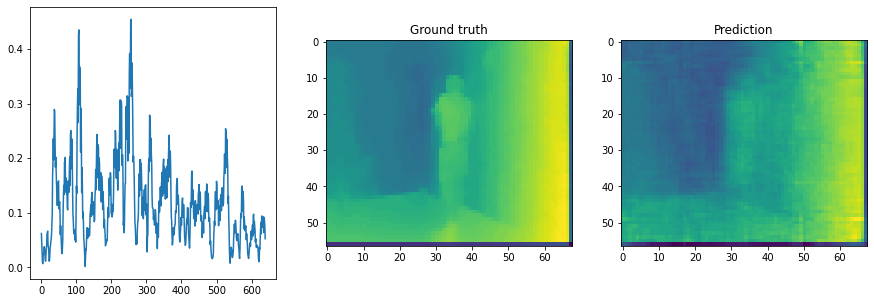

MSE 0.00015100017481017858


<Figure size 432x288 with 0 Axes>

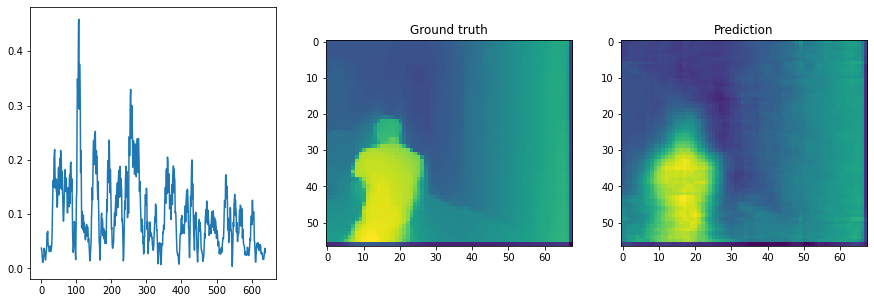

MSE 1.7396318071405403e-05


<Figure size 432x288 with 0 Axes>

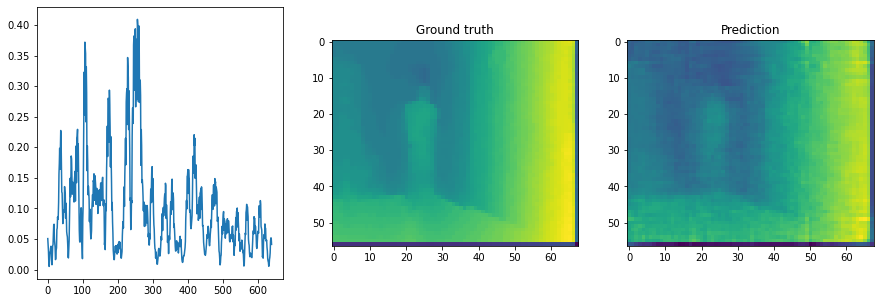

MSE 0.0006952451076358557


<Figure size 432x288 with 0 Axes>

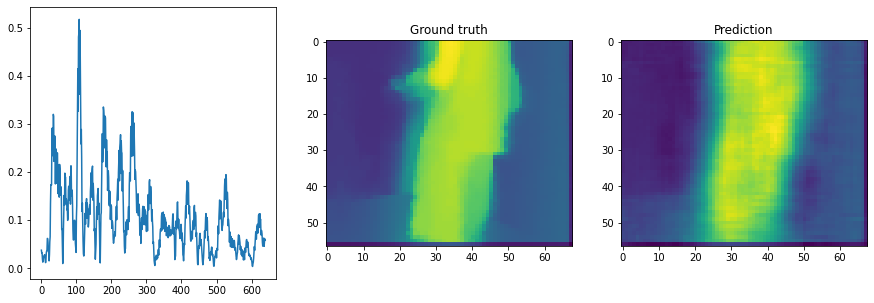

MSE 0.0003864853351842612


<Figure size 432x288 with 0 Axes>

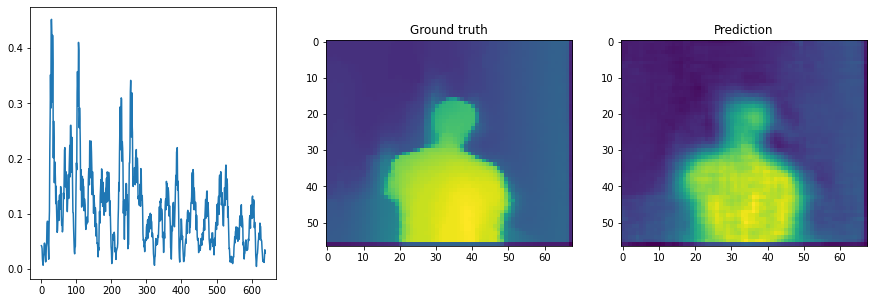

MSE 0.0003998402098659426


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [15]:
model.eval()
for idx, (audios, images) in enumerate(train_loader):
    audios = audios.to(device)
    pred_ims = model(audios)
    print(f"\n\nBatch {idx} ###############")
    for audio, image, pred_image in zip(audios, images, pred_ims):
        print(f"MSE {criterion( pred_image, image.to(device))}")
        audio_np = np.array(audio.to('cpu').detach().numpy())
        image_np = np.array(image.to('cpu').detach().numpy())
        pred_image_np = np.array(pred_image.to('cpu').detach().numpy())
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        axs[0].plot(audio_np)
        axs[1].imshow(image_np)
        axs[1].set_title("Ground truth")
        axs[2].imshow(pred_image_np)
        axs[2].set_title("Prediction")
        plt.show()
        plt.clf()
    if idx==0:
        break